# <center> Comparative analysis: deep Galerkin method (DGM), deep Ritz method (DRM), and physics-informed neural networks (PINN) for solving partial differential equations

DGM and PINN exhibit similarities in their loss functions derived from the primal formulation of the partial differential equation (PDE), yet they manifest key distinctions. Conventionally, PINN is trained on a fixed set of sample points randomly selected at the onset of the learning process and held constant throughout training. In contrast, DGM dynamically resamples training data at each iteration of the gradient descent process. Another distinguishing factor lies in the network architecture employed by each method. PINN utilizes a straightforward feed-forward network (for various neural network types) to approximate the PDE solution. On the other hand, DGM adopts a distinct network architecture featuring connections reminiscent of Long Short-Term Memory Networks and Highway Networks, with layers employing element-wise operations tailored to capture complicated, fast moving solutions. DRM (Deep Residual Network Method) employs a strategy to obtain a solution by minimizing an integral functional derived from the underlying Partial Differential Equation (PDE). To achieve this, DRM utilizes a deep neural network that features fully connected blocks and incorporates residual connections. The inclusion of these elements in the network's architecture is intended to effectively handle the vanishing gradient problem during the approximation process.

## ---------------------------------------------------------------------------------------------------------------------------------
##  <center> Physics-informed neural networks
## ---------------------------------------------------------------------------------------------------------------------------------

In this section, we'll explore physics-informed neural networks (PINNs) through a review of existing research, building a solid understanding, and coding implementations. PINNs act as function approximators, capable of estimating solutions to ordinary and partial differential equations (ODEs and PDEs) while staying consistent with the physical laws through the incorporation of constraints into loss functions.

### Approximate a function 

To approximate a given function, such as $y = x^3 + x^2 + x + 1$ within the interval $x \in (-5, 5)$, we gather a sufficient number of data points, denoted as $N$. Using a neural network architecture with $n$ layers, we employ the formulation $y_n = W^{[n]}(...\sigma(W^{[n-1]}x + b^{[n-1]}))+b^{[n]}$ to approximate $y \approx y_n$. To determine the neural network parameters, we define the loss function as:
$$Loss(\theta) = \frac{1}{M}\sum_{i=1}^{M}\big(y(x^{i})-y_n(x^i,\theta)\big)$$
In the following we implement the training and test by pytorch:

#### import library

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# import matplotlib.ticker
from sklearn.model_selection import train_test_split
import numpy as np
import time
# import scipy.io
import time

In [12]:
torch.set_default_dtype(torch.float)
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    print(torch.cuda.get_device_name())

#### data preparation

In [13]:
x_l = -1
x_r = 1
No_points = 2500
def f(x):
    y = x ** 3 + x ** 2 + x + 1
    return y

x = torch.linspace(x_l, x_r, No_points).view(-1, 1)
y = f(x)

indices = np.arange(No_points)
train_idx, test_idx, y_trainid, y_testid = train_test_split(indices, indices, test_size=0.2, random_state=42)
x_train = x[train_idx]
y_train = y[train_idx]
x_test = x[test_idx]
y_test = y[test_idx]
torch.manual_seed(123)
x_train = x_train.float().to(device)
y_train = y_train.float().to(device)


#### plot function

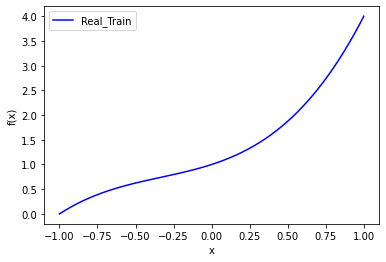

In [14]:
def plot_1d(x,y,x_train_plot=None,yh_plot=None):
    if x_train_plot==None:
        _, ax = plt.subplots()
        ax.plot(x.detach().numpy(), y.detach().numpy(), color='blue', label='Real_Train')
        ax.set_xlabel('x', color='black')
        ax.set_ylabel('f(x)', color='black')
        ax.tick_params(axis='y', color='black')
        ax.legend(loc='upper left')
    else:
        fig, ax = plt.subplots()
        ax.plot(x_train_plot.detach().cpu().numpy(), y_train_plot.detach().cpu().numpy(), color='blue', label='Real_Train')
        ax.plot(x_train_plot.detach().cpu().numpy(), yh_plot.detach().cpu().numpy(), color='red', label='Pred_Train')
        ax.set_xlabel('x', color='black')
        ax.set_ylabel('f(x)', color='black')
        ax.tick_params(axis='y', color='black')
        ax.legend(loc='upper left')

plot_1d(x,y)

#### model definition (loss function included)

In [12]:
class FPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()  # Call __init__ from parent class

        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
#         self.iter = 0

        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
            
        a = x.float()
        for i in range(len(layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def lossPINN(self, x, y):
        loss_val = self.loss_function(self.forward(x), y)
        return loss_val

In [13]:
layers = np.array([1, 50, 50, 20, 50, 50, 1])
model = FPINN(layers)
model.to(device)

iters = 15000
lr = 1e-3
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)
start_time = time.time()
print(model)

FPINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


#### Training

tensor(2.6150, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(1.7892e-05, grad_fn=<MseLossBackward0>)
tensor(7.0024e-06, grad_fn=<MseLossBackward0>)
tensor(3.4488e-06, grad_fn=<MseLossBackward0>)
tensor(2.0349e-06, grad_fn=<MseLossBackward0>)
tensor(1.7979e-06, grad_fn=<MseLossBackward0>)
tensor(1.2983e-05, grad_fn=<MseLossBackward0>)
tensor(2.3014e-06, grad_fn=<MseLossBackward0>)
tensor(1.1209e-06, grad_fn=<MseLossBackward0>)
0.032140493392944336
0.03210186958312988
Wall time: 3min 28s


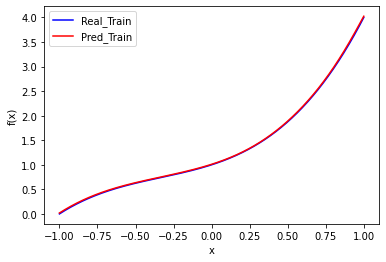

In [15]:
%%time
for i in range(iters):
    optimizer.zero_grad()
    yh = model(x_train)
    loss = model.lossPINN(x_train, y_train)
    loss.backward()
    optimizer.step()
    if i % (iters / 10) == 0:
        print(loss)

yf = model(x_train)
yf_test = model(x_test.float().to(device))

_, id_train = torch.sort(x_train.squeeze(1))
_, id_test = torch.sort(x_test.squeeze(1))
x_train_plot = x_train[id_train]
y_train_plot = y_train[id_train]
yf_plot = yf[id_train]
x_test_plot = x_test[id_test]
y_test_plot = y_test[id_test]
yf_test_plot = yf_test[id_test]

plot = plot_1d(x_train_plot,y_train_plot,x_train_plot,yf_plot)
 

print(torch.max(abs(y_train_plot - yf_plot)).item())
print(torch.max(abs(y_test_plot - yf_test_plot)).item())





# x_train_plot_np = x_train_plot.detach().squeeze().numpy()
# y_train_plot_np = y_train_plot.detach().squeeze().numpy()
# yf_plot_np = yf_plot.detach().squeeze().numpy()

# # Creating a DataFrame for plotly
# df_train = pd.DataFrame({'x_train': x_train_plot_np, 'y_train': y_train_plot_np})
# df_yf = pd.DataFrame({'x_train': x_train_plot_np, 'yf_plot': yf_plot_np})

# # Plotting with plotly
# fig = px.line(df_train, x='x_train', y='y_train', title='Training Data and Predictions')
# fig.add_scatter(x=df_yf['x_train'], y=df_yf['yf_plot'], mode='lines', name='Model Prediction')

# # Enable scroll zoom
# fig.show(config={'scrollZoom': True})

 

In [59]:

print(torch.max(abs(y_train_plot - yf_plot)))
print(torch.max(abs(y_test_plot - yf_test_plot)))

tensor(0.0321, grad_fn=<MaxBackward1>)
tensor(0.0321, grad_fn=<MaxBackward1>)


### --------------------------------------------------------------------------------------------------------------------------------------------------------------
### --------------------------------------------------------------------------------------------------------------------------------------------------------------

### PINN for Poisson equation

#### Problem setup --- Continuous time models

In this section, we define the neural network that will be used to solve the partial differential equation (PDE) continuously. The approach is similar to designing an exact solution that satisfies the boundary and initial conditions. However, instead of substituting the PDE into the solution, we constrain the right-hand side of the equation to ensure that it is zero or any given functions. This process is known as the training process.

Define $f(t,x)$ to be given by the left hand side of equation $u_t + \mathcal{N}[u;\lambda] = 0$:
\begin{align}
f:=u_t + \mathcal{N}[u]\label{eqf}\tag{1}
\end{align}

and proceed by approximating $u(t,x)$ by a deep neural network. This assumption along with equation (\ref{eqf}) result in a physics-informed neural network $f(t, x)$.

This network can be derived by applying the chain rule for differentiating compositions of functions using automatic differentiation, and has the same parameters as the network representing $u(t, x)$, albeit with different activation functions due to the action of the differential operator $\mathcal{N}$. The shared parameters between the neural networks $u(t, x)$ and $f(t, x)$ can be learned by minimizing the mean squared error loss

$$MSE = MSE_u + MSE_f$$
where
$$MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}|u(t^{i}_u,x_u^i)-u^{i}|^2$$
and 
$$MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t^{i}_f,x_f^i)|^2$$

To illustrate the application of Physics-Informed Neural Networks (PINN) for solving partial differential equations, we provide the code implementation for the Poisson equation below:

#### Poisson equation (2D)

$$-\Delta u =f(x,y)$$

 

#### Problem

$$-\Delta u=2\pi^2sin(\pi x)sin(\pi y)$$

#### Boundary Conditions:

$$u(-1,y)=0,\  u(1,y) =0, \ u(x,-1)=0,\  u(x,1) =0$$

#### Exact solution:

$$u(x)=sin(\pi x)sin(\pi y)$$


So the residual will be:

$$0=\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}+2\pi^2sin(\pi x)sin(\pi y)$$

Note: remeber that our neural network $NN(x,y)\approx u(x,y)$ so:

$$\frac{\partial^2NN}{\partial x^2}\approx\frac{\partial^2u}{\partial x^2}$$
$$\frac{\partial^2NN}{\partial y^2}\approx\frac{\partial^2u}{\partial y^2}$$

$$f=\frac{\partial^2NN}{\partial x^2}+\frac{\partial^2NN}{\partial y^2}+2\pi^2sin(\pi x)sin(\pi y)\rightarrow 0$$

Set two functions to describe our boundary conditions:

$$f_{BC_v}(x)=1-|x|,\  x = \pm  1 \ y \in (-1,1)$$
$$f_{BC_h}(x)=1-|y|,\  y = \pm 1 \ x \in (-1,1)$$

#### import library

In [11]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import matplotlib.pyplot as plt

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling

In [12]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


#### function definition

In [13]:
def f_BCv(x):
    return 1-torch.abs(x)

def f_BCh(y):
    return 1-torch.abs(y)

def f_real(x,y):
    return torch.sin(np.pi*x)*torch.sin(np.pi*y)

def PDE(x,y):
    return -2*(np.pi**2)*torch.sin(np.pi*x)*torch.sin(np.pi*y)




def relative_error(x_error):
    
    u_predict = model(x)
    u_real = f_real(x,y)
    value = torch.sqrt(torch.sum((u_predict - u_real )**2))/torch.sqrt(torch.sum((u_real )**2))
    return value


def plot3D(X,Y,f,title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), f.numpy(), cmap='jet', edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    ax.set_title(title)
    plt.show()
    
    
def plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar):
    plt.imshow(f.numpy(), cmap='jet', origin='lower', extent=[x_l, x_r, y_l, y_r])
    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title_colorbar)

    plt.show()

#### data preparation

In [14]:
steps=5000
lr=1e-3
Nu=1000
Nf=10000

x_l=-1
x_r=1
y_l=-1
y_r=1
total_points=2000
x = torch.linspace(x_l,x_r,total_points).view((-1,1))
y = torch.linspace(y_l,y_r,total_points).view((-1,1))
X, Y = torch.meshgrid(x.view(-1,), y.view(-1,), indexing='ij')
f = f_real(X,Y)

# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],Y.transpose(1,0).flatten()[:,None]))
v_test=f.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 

In [15]:
#Boundary Conditions
#Left Edge 
left_X=torch.hstack((X[0,:][:,None],Y[0,:][:,None])) # First column # The [:,None] is to give it the right dimension
vleft_boundary = f_BCv(left_X[:,0]).unsqueeze(1)

#right Edge
right_X=torch.hstack((X[-1,:][:,None],Y[-1,:][:,None]))
vright_boundary = f_BCv(right_X[:,0]).unsqueeze(1)

#Bottom Edge
bottom_X=torch.hstack((X[:,0][:,None],Y[:,0][:,None])) # First row # The [:,None] is to give it the right dimension
vbottom_boundary = f_BCh(bottom_X[:,-1]) .unsqueeze(1)

#Top Edge
top_X=torch.hstack((X[:,0][:,None],Y[:,-1][:,None])) # First row # The [:,None] is to give it the right dimension
vtop_boundary = f_BCh(top_X[:,-1]).unsqueeze(1)
 
# #Get all the training data into the same dataset
X_train=torch.vstack([left_X,right_X,bottom_X,top_X])
v_train=torch.vstack([vleft_boundary,vright_boundary,vbottom_boundary,vtop_boundary])

#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
v_train_Nu=v_train[idx,:]
  
# Collocation Points (Evaluate our PDe) #Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and y
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

#### model definition

In [16]:
class PINN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,X):
        if torch.is_tensor(X) != True:         
            X = torch.from_numpy(X)                
        a = X.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a

    #Loss BC
    def lossBC(self,X_BC,f_BC):
        loss_BC=self.loss_function(self.forward(X_BC),f_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,X_PDE):
        g=X_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x =   f_X[:,0]
        grad_y = f_X[:,1]
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        f_YY = autograd.grad(grad_y, g, grad_outputs=torch.ones_like(grad_y), create_graph=True)[0][:, 1]
        
        solu = 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        delta_f=f_XX.unsqueeze(1) + f_YY.unsqueeze(1) + solu
        return self.loss_function(delta_f,f_hat)

    #     + 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        
    def loss(self,X_BC,f_BC,X_PDE):
        loss_bc=self.lossBC(X_BC,f_BC)
        loss_pde=self.lossPDE(X_PDE)
        return loss_bc+loss_pde

In [17]:
layers = np.array([2, 50, 50, 20, 50, 50, 1])
model = PINN(layers)
model.to(device)
params = list(model.parameters())
print(model)

PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


#### model training

In [18]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
v_train_Nu=v_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function
print(f_hat.shape)

X_test=x_test.float().to(device) # the input dataset (complete)
V_test=v_test.float().to(device) # the real solution 

optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)

torch.Size([11000, 1])


In [20]:
%%time
for i in range(steps):
    optimizer.zero_grad() 
    loss = model.loss(X_train_Nu,v_train_Nu,X_train_Nf)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
     
    if i%200==0:
        print(loss)
         
         



tensor(88.0907, grad_fn=<AddBackward0>)
tensor(0.8845, grad_fn=<AddBackward0>)
tensor(0.0612, grad_fn=<AddBackward0>)
tensor(0.0328, grad_fn=<AddBackward0>)
tensor(0.0245, grad_fn=<AddBackward0>)
tensor(0.0198, grad_fn=<AddBackward0>)
tensor(0.0171, grad_fn=<AddBackward0>)
tensor(0.0148, grad_fn=<AddBackward0>)
tensor(0.0137, grad_fn=<AddBackward0>)
tensor(0.0123, grad_fn=<AddBackward0>)
tensor(0.0140, grad_fn=<AddBackward0>)
tensor(0.0105, grad_fn=<AddBackward0>)
tensor(0.0107, grad_fn=<AddBackward0>)
tensor(0.0178, grad_fn=<AddBackward0>)
tensor(0.0088, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
tensor(0.0085, grad_fn=<AddBackward0>)
tensor(0.0070, grad_fn=<AddBackward0>)
tensor(0.0084, grad_fn=<AddBackward0>)
tensor(0.0061, grad_fn=<AddBackward0>)
tensor(0.0109, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0062, grad_fn=<AddBackward0>)
tensor(0.0041, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
Wall time: 17min 15s


#### result plot

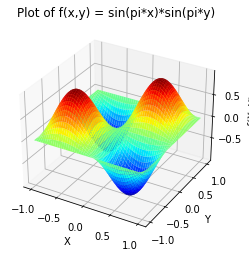

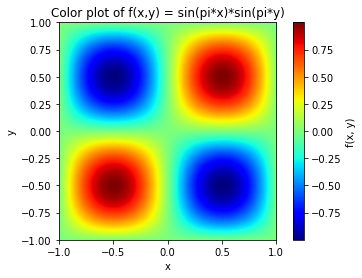

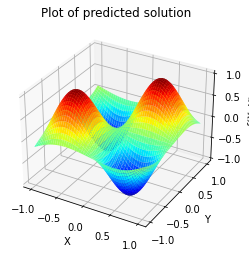

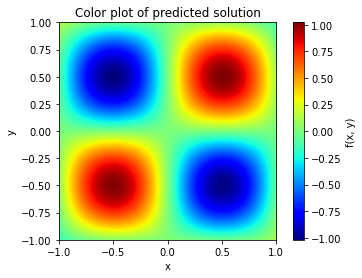

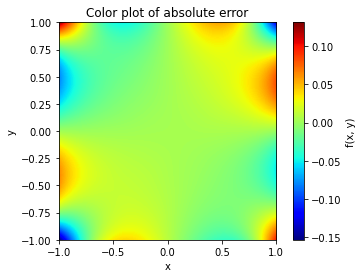

tensor([[0.1531, 0.1525, 0.1519,  ..., 0.1018, 0.1025, 0.1031],
        [0.1524, 0.1518, 0.1512,  ..., 0.1016, 0.1022, 0.1028],
        [0.1518, 0.1512, 0.1506,  ..., 0.1013, 0.1019, 0.1025],
        ...,
        [0.1294, 0.1289, 0.1285,  ..., 0.1289, 0.1296, 0.1302],
        [0.1302, 0.1297, 0.1292,  ..., 0.1296, 0.1302, 0.1309],
        [0.1309, 0.1304, 0.1299,  ..., 0.1302, 0.1308, 0.1315]])
tensor(0.0415)


In [22]:
y_predict = model(x_test).detach()
 
reshaped_f = torch.reshape(y_predict, X.shape).transpose(1,0)

title = 'Plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot3D(X,Y,f,title)
title_colorbar = 'Color plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar)

title = 'Plot of predicted solution'
plot3D(X,Y,reshaped_f,title)
title_colorbar = 'Color plot of predicted solution'
plot_heat(x_l,x_r,y_l,y_r,reshaped_f,title_colorbar)

title_colorbar = 'Color plot of absolute error' 
plot_heat(x_l,x_r,y_l,y_r,reshaped_f-f,title_colorbar) 
print(abs(reshaped_f-f))
print(abs(reshaped_f-f).sum()/(f.size()[0]*f.size()[1])/(abs(f).sum()/(f.size()[0]*f.size()[1])))

## ---------------------------------------------------------------------------------------------------------------------------------
##  <center> Deep Galerkin Method
## --------------------------------------------------------------------------------------------------------------------------------
#### https://www.sciencedirect.com/science/article/abs/pii/S0021999118305527

### 2-D Poisson

The problem is set to be  $$-\Delta u  = f$$

#### import library

In [1]:
# %%
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
from math import *

In [2]:
torch.set_default_dtype(torch.float32)  # Set the default data type
torch.set_default_device('cpu')  # Set the default device (e.g., 'cuda' for GPU)

#### fundion definition

In [3]:
# exact solution
def u_exact(x):  
    u_intermediate  = torch.sin(pi*x)
    u_real = (u_intermediate[:,0]*u_intermediate[:,1]).reshape((-1,1)) # u_intermediate.sum(1) 
    return u_real

# %%
def f_source(x):
    f_intermediate = torch.sin(pi*x)
    f_right_hand = 2*pi**2*(f_intermediate[:,0]*f_intermediate[:,1]).reshape((-1,1)) # f_intermediate.sum(1) 
    return f_right_hand


def relative_error(x):
    
    u_predict = model(x)
    u_real = u_exact(x)
    value = torch.sqrt(torch.sum((u_predict - u_real )**2))/torch.sqrt(torch.sum((u_real )**2))
    return value

#### data preparation

In [4]:
Data_size = 2000
x_l = -1
x_r = 1
y_l = -1
y_r = 1
# %%
dimension = 2
def Gendata():
    x = torch.rand(Data_size, dimension)
    x = 2*x-1         
    return x

In [5]:
x = Gendata()
uexact = u_exact(x)
ff = f_source(x)
print(ff)
print(uexact*2*np.pi**2)

tensor([[ 19.4325],
        [ -8.4276],
        [  3.9888],
        ...,
        [ 18.0237],
        [ -2.5846],
        [-18.7153]])
tensor([[ 19.4325],
        [ -8.4276],
        [  3.9888],
        ...,
        [ 18.0237],
        [ -2.5846],
        [-18.7153]])


#### model definition

In [6]:
class Linear(nn.Module):
    #""" Copy of linear module from Pytorch, modified to have a Xavier init,
    #    TODO : figure out what to do with the bias"
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
#         torch.nn.init.xavier_uniform_(self.weight)
        nn.init.xavier_normal_(self.weight, gain=1.0)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?

    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight, self.bias)

#     def extra_repr(self):
#         return 'in_features={}, out_features={}, bias={}'.format(
#             self.in_features, self.out_features, self.bias is not None
#         )


class DGM_layer(nn.Module):
    #""" See readme for paper source"""
    def __init__(self, in_features, out_feature, residual=False):
        super(DGM_layer, self).__init__()
        self.residual = residual

        self.Z = Linear(out_feature, out_feature)
        self.UZ = Linear(in_features, out_feature, bias=True)
        self.G = Linear(out_feature, out_feature)
        self.UG = Linear(in_features, out_feature, bias=True)
        self.R = Linear(out_feature, out_feature)
        self.UR = Linear(in_features, out_feature, bias=True)
        self.H = Linear(out_feature, out_feature)
        self.UH = Linear(in_features, out_feature, bias=True)

    def forward(self, x, s):
        
        z = torch.tanh(self.UZ(x) + self.Z(s))
        g = torch.tanh(self.UG(x) + self.G(s))
        r = torch.tanh(self.UR(x) + self.R(s))
        h = torch.tanh(self.UH(x) + self.H(s * r))
        return (1 - g) * h + z * s

class DGM_model(nn.Module):

    def __init__(self, in_size, out_size, neurons, depth):
        super(DGM_model, self).__init__()
        self.input_layer = Linear(in_size, neurons)
        self.middle_layer = nn.ModuleList([DGM_layer(in_size, neurons) for i in range(depth)])
        self.final_layer = Linear(neurons, out_size)
        

    def forward(self, X):
        s = torch.tanh(self.input_layer(X))
        for i, layer in enumerate(self.middle_layer):
            s = torch.tanh(layer(X, s))

        return self.final_layer(s)

    def Loss_function(self,x):
        g=x.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x = f_X[:,0]
        grad_y = f_X[:,1]
     
        
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        f_YY = autograd.grad(grad_y, g, grad_outputs=torch.ones_like(grad_y), create_graph=True)[0][:, 1]
    
        
        
        laplace_f=f_XX.unsqueeze(1) + f_YY.unsqueeze(1)
        
        
        
        f_right = f_source(x)
        part_1 = torch.sum((-laplace_f - f_right)**2)/x.size()[0]

        Nb = 100
        xa1 = torch.rand(Nb, dimension) 
        xa1 = 2*xa1-1
        xa1[:, 0] = torch.zeros(Nb)-1
        xa2 = torch.rand(Nb, dimension) 
        xa2 = 2*xa2-1
        xa2[:, 0] = torch.ones(Nb)
        xb1 = torch.rand(Nb, dimension) 
        xb1 = 2*xb1-1
        xb1[:, 1] = torch.zeros(Nb)-1
        xb2 = torch.rand(Nb, dimension) 
        xb2 = 2*xb2-1
        xb2[:, 1] = torch.ones(Nb)
        
        sa1 = (torch.sum((model(xa1)-u_exact(xa1))**2)/xa1.size()[0]) 
        sa2 = (torch.sum((model(xa2)-u_exact(xa2))**2)/xa2.size()[0]) 
        sb1 = (torch.sum((model(xb1)-u_exact(xb1))**2)/xb1.size()[0]) 
        sb2 = (torch.sum((model(xb2)-u_exact(xb2))**2)/xb2.size()[0]) 
        
        part_2 = sa1 + sa2 + sb1 + sb2 

        lambda1 = 100.0
        return part_1 + lambda1 * part_2 / 4

In [7]:
model = DGM_model(2, 1, 50, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### model training

In [8]:
import torch.optim as optim
import torch.nn as nn
import time

traintime = 5000

# %%
time_start = time.time()
for i in range(traintime):
    optimizer.zero_grad()
    x = Gendata()
#     x.requires_grad = True
    losses = model.Loss_function(x)
    losses.backward()
    optimizer.step()
    error = relative_error(x)
     
    
    if i % 1 == 0:
        print("current epoch is: ", i)
        print("current loss is: ", losses.detach())
        print("current relative error is: ", error.detach())
time_end = time.time()
print('total time is: ', time_end-time_start, 'seconds')

# %%






current epoch is:  0
current loss is:  tensor(212.3303)
current relative error is:  tensor(2.0378)
current epoch is:  1
current loss is:  tensor(180.7077)
current relative error is:  tensor(1.8186)
current epoch is:  2
current loss is:  tensor(161.8484)
current relative error is:  tensor(1.5141)
current epoch is:  3
current loss is:  tensor(138.7091)
current relative error is:  tensor(1.3340)
current epoch is:  4
current loss is:  tensor(130.4377)
current relative error is:  tensor(1.1720)
current epoch is:  5
current loss is:  tensor(118.3377)
current relative error is:  tensor(1.1050)
current epoch is:  6
current loss is:  tensor(109.8626)
current relative error is:  tensor(1.0947)
current epoch is:  7
current loss is:  tensor(107.6226)
current relative error is:  tensor(1.1370)
current epoch is:  8
current loss is:  tensor(105.5247)
current relative error is:  tensor(1.1848)
current epoch is:  9
current loss is:  tensor(107.3880)
current relative error is:  tensor(1.2175)
current ep

current epoch is:  83
current loss is:  tensor(94.5838)
current relative error is:  tensor(0.9390)
current epoch is:  84
current loss is:  tensor(91.7284)
current relative error is:  tensor(0.9349)
current epoch is:  85
current loss is:  tensor(91.3097)
current relative error is:  tensor(0.9339)
current epoch is:  86
current loss is:  tensor(94.3740)
current relative error is:  tensor(0.9319)
current epoch is:  87
current loss is:  tensor(90.4723)
current relative error is:  tensor(0.9295)
current epoch is:  88
current loss is:  tensor(95.0208)
current relative error is:  tensor(0.9286)
current epoch is:  89
current loss is:  tensor(93.2290)
current relative error is:  tensor(0.9265)
current epoch is:  90
current loss is:  tensor(93.6406)
current relative error is:  tensor(0.9261)
current epoch is:  91
current loss is:  tensor(92.2662)
current relative error is:  tensor(0.9235)
current epoch is:  92
current loss is:  tensor(88.5351)
current relative error is:  tensor(0.9177)
current ep

current epoch is:  248
current loss is:  tensor(2.5099)
current relative error is:  tensor(0.1315)
current epoch is:  249
current loss is:  tensor(2.6132)
current relative error is:  tensor(0.1272)
current epoch is:  250
current loss is:  tensor(2.4153)
current relative error is:  tensor(0.1143)
current epoch is:  251
current loss is:  tensor(2.4222)
current relative error is:  tensor(0.1069)
current epoch is:  252
current loss is:  tensor(2.4991)
current relative error is:  tensor(0.0969)
current epoch is:  253
current loss is:  tensor(2.4043)
current relative error is:  tensor(0.0888)
current epoch is:  254
current loss is:  tensor(2.1653)
current relative error is:  tensor(0.0863)
current epoch is:  255
current loss is:  tensor(2.3797)
current relative error is:  tensor(0.0808)
current epoch is:  256
current loss is:  tensor(2.3852)
current relative error is:  tensor(0.0908)
current epoch is:  257
current loss is:  tensor(2.1569)
current relative error is:  tensor(0.0990)
current ep

current epoch is:  333
current loss is:  tensor(0.9106)
current relative error is:  tensor(0.0527)
current epoch is:  334
current loss is:  tensor(1.0457)
current relative error is:  tensor(0.0521)
current epoch is:  335
current loss is:  tensor(0.8078)
current relative error is:  tensor(0.0453)
current epoch is:  336
current loss is:  tensor(0.9444)
current relative error is:  tensor(0.0440)
current epoch is:  337
current loss is:  tensor(0.8625)
current relative error is:  tensor(0.0389)
current epoch is:  338
current loss is:  tensor(0.9198)
current relative error is:  tensor(0.0395)
current epoch is:  339
current loss is:  tensor(0.8565)
current relative error is:  tensor(0.0403)
current epoch is:  340
current loss is:  tensor(0.8723)
current relative error is:  tensor(0.0422)
current epoch is:  341
current loss is:  tensor(0.9367)
current relative error is:  tensor(0.0457)
current epoch is:  342
current loss is:  tensor(0.8780)
current relative error is:  tensor(0.0461)
current ep

current epoch is:  417
current loss is:  tensor(0.5042)
current relative error is:  tensor(0.0318)
current epoch is:  418
current loss is:  tensor(0.5066)
current relative error is:  tensor(0.0398)
current epoch is:  419
current loss is:  tensor(0.5471)
current relative error is:  tensor(0.0414)
current epoch is:  420
current loss is:  tensor(0.5473)
current relative error is:  tensor(0.0376)
current epoch is:  421
current loss is:  tensor(0.5037)
current relative error is:  tensor(0.0372)
current epoch is:  422
current loss is:  tensor(0.5410)
current relative error is:  tensor(0.0381)
current epoch is:  423
current loss is:  tensor(0.5387)
current relative error is:  tensor(0.0346)
current epoch is:  424
current loss is:  tensor(0.5095)
current relative error is:  tensor(0.0302)
current epoch is:  425
current loss is:  tensor(0.5473)
current relative error is:  tensor(0.0347)
current epoch is:  426
current loss is:  tensor(0.4859)
current relative error is:  tensor(0.0358)
current ep

current epoch is:  500
current loss is:  tensor(0.3745)
current relative error is:  tensor(0.0315)
current epoch is:  501
current loss is:  tensor(0.3882)
current relative error is:  tensor(0.0310)
current epoch is:  502
current loss is:  tensor(0.4007)
current relative error is:  tensor(0.0284)
current epoch is:  503
current loss is:  tensor(0.3890)
current relative error is:  tensor(0.0286)
current epoch is:  504
current loss is:  tensor(0.3842)
current relative error is:  tensor(0.0290)
current epoch is:  505
current loss is:  tensor(0.3904)
current relative error is:  tensor(0.0275)
current epoch is:  506
current loss is:  tensor(0.3973)
current relative error is:  tensor(0.0296)
current epoch is:  507
current loss is:  tensor(0.3790)
current relative error is:  tensor(0.0339)
current epoch is:  508
current loss is:  tensor(0.4035)
current relative error is:  tensor(0.0350)
current epoch is:  509
current loss is:  tensor(0.3869)
current relative error is:  tensor(0.0344)
current ep

current epoch is:  583
current loss is:  tensor(0.2692)
current relative error is:  tensor(0.0212)
current epoch is:  584
current loss is:  tensor(0.3010)
current relative error is:  tensor(0.0223)
current epoch is:  585
current loss is:  tensor(0.2718)
current relative error is:  tensor(0.0257)
current epoch is:  586
current loss is:  tensor(0.2921)
current relative error is:  tensor(0.0248)
current epoch is:  587
current loss is:  tensor(0.2848)
current relative error is:  tensor(0.0272)
current epoch is:  588
current loss is:  tensor(0.2569)
current relative error is:  tensor(0.0284)
current epoch is:  589
current loss is:  tensor(0.2731)
current relative error is:  tensor(0.0281)
current epoch is:  590
current loss is:  tensor(0.3056)
current relative error is:  tensor(0.0273)
current epoch is:  591
current loss is:  tensor(0.2793)
current relative error is:  tensor(0.0245)
current epoch is:  592
current loss is:  tensor(0.2930)
current relative error is:  tensor(0.0240)
current ep

current epoch is:  667
current loss is:  tensor(0.2430)
current relative error is:  tensor(0.0216)
current epoch is:  668
current loss is:  tensor(0.2256)
current relative error is:  tensor(0.0216)
current epoch is:  669
current loss is:  tensor(0.2111)
current relative error is:  tensor(0.0237)
current epoch is:  670
current loss is:  tensor(0.2351)
current relative error is:  tensor(0.0251)
current epoch is:  671
current loss is:  tensor(0.2487)
current relative error is:  tensor(0.0231)
current epoch is:  672
current loss is:  tensor(0.2478)
current relative error is:  tensor(0.0232)
current epoch is:  673
current loss is:  tensor(0.2248)
current relative error is:  tensor(0.0211)
current epoch is:  674
current loss is:  tensor(0.1958)
current relative error is:  tensor(0.0209)
current epoch is:  675
current loss is:  tensor(0.2296)
current relative error is:  tensor(0.0211)
current epoch is:  676
current loss is:  tensor(0.2210)
current relative error is:  tensor(0.0222)
current ep

current epoch is:  750
current loss is:  tensor(0.1583)
current relative error is:  tensor(0.0188)
current epoch is:  751
current loss is:  tensor(0.1754)
current relative error is:  tensor(0.0192)
current epoch is:  752
current loss is:  tensor(0.2026)
current relative error is:  tensor(0.0179)
current epoch is:  753
current loss is:  tensor(0.1797)
current relative error is:  tensor(0.0181)
current epoch is:  754
current loss is:  tensor(0.2005)
current relative error is:  tensor(0.0210)
current epoch is:  755
current loss is:  tensor(0.1679)
current relative error is:  tensor(0.0197)
current epoch is:  756
current loss is:  tensor(0.1695)
current relative error is:  tensor(0.0222)
current epoch is:  757
current loss is:  tensor(0.1819)
current relative error is:  tensor(0.0206)
current epoch is:  758
current loss is:  tensor(0.1691)
current relative error is:  tensor(0.0184)
current epoch is:  759
current loss is:  tensor(0.2049)
current relative error is:  tensor(0.0187)
current ep

current epoch is:  835
current loss is:  tensor(0.1501)
current relative error is:  tensor(0.0183)
current epoch is:  836
current loss is:  tensor(0.1399)
current relative error is:  tensor(0.0190)
current epoch is:  837
current loss is:  tensor(0.1297)
current relative error is:  tensor(0.0163)
current epoch is:  838
current loss is:  tensor(0.1520)
current relative error is:  tensor(0.0164)
current epoch is:  839
current loss is:  tensor(0.1475)
current relative error is:  tensor(0.0151)
current epoch is:  840
current loss is:  tensor(0.1401)
current relative error is:  tensor(0.0142)
current epoch is:  841
current loss is:  tensor(0.1406)
current relative error is:  tensor(0.0143)
current epoch is:  842
current loss is:  tensor(0.1269)
current relative error is:  tensor(0.0171)
current epoch is:  843
current loss is:  tensor(0.1382)
current relative error is:  tensor(0.0201)
current epoch is:  844
current loss is:  tensor(0.1698)
current relative error is:  tensor(0.0212)
current ep

current epoch is:  919
current loss is:  tensor(0.1060)
current relative error is:  tensor(0.0118)
current epoch is:  920
current loss is:  tensor(0.1006)
current relative error is:  tensor(0.0126)
current epoch is:  921
current loss is:  tensor(0.1078)
current relative error is:  tensor(0.0155)
current epoch is:  922
current loss is:  tensor(0.1132)
current relative error is:  tensor(0.0148)
current epoch is:  923
current loss is:  tensor(0.1082)
current relative error is:  tensor(0.0152)
current epoch is:  924
current loss is:  tensor(0.1092)
current relative error is:  tensor(0.0148)
current epoch is:  925
current loss is:  tensor(0.1028)
current relative error is:  tensor(0.0120)
current epoch is:  926
current loss is:  tensor(0.1346)
current relative error is:  tensor(0.0129)
current epoch is:  927
current loss is:  tensor(0.1070)
current relative error is:  tensor(0.0139)
current epoch is:  928
current loss is:  tensor(0.1110)
current relative error is:  tensor(0.0148)
current ep

current epoch is:  1004
current loss is:  tensor(0.0858)
current relative error is:  tensor(0.0118)
current epoch is:  1005
current loss is:  tensor(0.0887)
current relative error is:  tensor(0.0120)
current epoch is:  1006
current loss is:  tensor(0.1128)
current relative error is:  tensor(0.0150)
current epoch is:  1007
current loss is:  tensor(0.0886)
current relative error is:  tensor(0.0135)
current epoch is:  1008
current loss is:  tensor(0.1035)
current relative error is:  tensor(0.0126)
current epoch is:  1009
current loss is:  tensor(0.0898)
current relative error is:  tensor(0.0113)
current epoch is:  1010
current loss is:  tensor(0.0728)
current relative error is:  tensor(0.0106)
current epoch is:  1011
current loss is:  tensor(0.0923)
current relative error is:  tensor(0.0123)
current epoch is:  1012
current loss is:  tensor(0.0747)
current relative error is:  tensor(0.0116)
current epoch is:  1013
current loss is:  tensor(0.0941)
current relative error is:  tensor(0.0126)


current epoch is:  1086
current loss is:  tensor(0.0713)
current relative error is:  tensor(0.0105)
current epoch is:  1087
current loss is:  tensor(0.0696)
current relative error is:  tensor(0.0101)
current epoch is:  1088
current loss is:  tensor(0.0628)
current relative error is:  tensor(0.0102)
current epoch is:  1089
current loss is:  tensor(0.0654)
current relative error is:  tensor(0.0105)
current epoch is:  1090
current loss is:  tensor(0.0583)
current relative error is:  tensor(0.0106)
current epoch is:  1091
current loss is:  tensor(0.0717)
current relative error is:  tensor(0.0112)
current epoch is:  1092
current loss is:  tensor(0.0707)
current relative error is:  tensor(0.0107)
current epoch is:  1093
current loss is:  tensor(0.0741)
current relative error is:  tensor(0.0122)
current epoch is:  1094
current loss is:  tensor(0.0679)
current relative error is:  tensor(0.0114)
current epoch is:  1095
current loss is:  tensor(0.0661)
current relative error is:  tensor(0.0099)


current epoch is:  1168
current loss is:  tensor(0.0603)
current relative error is:  tensor(0.0113)
current epoch is:  1169
current loss is:  tensor(0.0533)
current relative error is:  tensor(0.0096)
current epoch is:  1170
current loss is:  tensor(0.0590)
current relative error is:  tensor(0.0094)
current epoch is:  1171
current loss is:  tensor(0.0646)
current relative error is:  tensor(0.0094)
current epoch is:  1172
current loss is:  tensor(0.0535)
current relative error is:  tensor(0.0092)
current epoch is:  1173
current loss is:  tensor(0.0572)
current relative error is:  tensor(0.0093)
current epoch is:  1174
current loss is:  tensor(0.0594)
current relative error is:  tensor(0.0095)
current epoch is:  1175
current loss is:  tensor(0.0656)
current relative error is:  tensor(0.0101)
current epoch is:  1176
current loss is:  tensor(0.0586)
current relative error is:  tensor(0.0103)
current epoch is:  1177
current loss is:  tensor(0.0605)
current relative error is:  tensor(0.0097)


current epoch is:  1250
current loss is:  tensor(0.0520)
current relative error is:  tensor(0.0084)
current epoch is:  1251
current loss is:  tensor(0.0531)
current relative error is:  tensor(0.0106)
current epoch is:  1252
current loss is:  tensor(0.0448)
current relative error is:  tensor(0.0098)
current epoch is:  1253
current loss is:  tensor(0.0455)
current relative error is:  tensor(0.0074)
current epoch is:  1254
current loss is:  tensor(0.0468)
current relative error is:  tensor(0.0067)
current epoch is:  1255
current loss is:  tensor(0.0462)
current relative error is:  tensor(0.0069)
current epoch is:  1256
current loss is:  tensor(0.0425)
current relative error is:  tensor(0.0081)
current epoch is:  1257
current loss is:  tensor(0.0447)
current relative error is:  tensor(0.0108)
current epoch is:  1258
current loss is:  tensor(0.0480)
current relative error is:  tensor(0.0105)
current epoch is:  1259
current loss is:  tensor(0.0511)
current relative error is:  tensor(0.0079)


current epoch is:  1332
current loss is:  tensor(0.0503)
current relative error is:  tensor(0.0077)
current epoch is:  1333
current loss is:  tensor(0.0409)
current relative error is:  tensor(0.0080)
current epoch is:  1334
current loss is:  tensor(0.0390)
current relative error is:  tensor(0.0089)
current epoch is:  1335
current loss is:  tensor(0.0373)
current relative error is:  tensor(0.0078)
current epoch is:  1336
current loss is:  tensor(0.0335)
current relative error is:  tensor(0.0065)
current epoch is:  1337
current loss is:  tensor(0.0394)
current relative error is:  tensor(0.0066)
current epoch is:  1338
current loss is:  tensor(0.0395)
current relative error is:  tensor(0.0067)
current epoch is:  1339
current loss is:  tensor(0.0387)
current relative error is:  tensor(0.0079)
current epoch is:  1340
current loss is:  tensor(0.0399)
current relative error is:  tensor(0.0080)
current epoch is:  1341
current loss is:  tensor(0.0327)
current relative error is:  tensor(0.0075)


current epoch is:  1415
current loss is:  tensor(0.0331)
current relative error is:  tensor(0.0063)
current epoch is:  1416
current loss is:  tensor(0.0344)
current relative error is:  tensor(0.0074)
current epoch is:  1417
current loss is:  tensor(0.0288)
current relative error is:  tensor(0.0063)
current epoch is:  1418
current loss is:  tensor(0.0324)
current relative error is:  tensor(0.0079)
current epoch is:  1419
current loss is:  tensor(0.0317)
current relative error is:  tensor(0.0086)
current epoch is:  1420
current loss is:  tensor(0.0426)
current relative error is:  tensor(0.0078)
current epoch is:  1421
current loss is:  tensor(0.0306)
current relative error is:  tensor(0.0067)
current epoch is:  1422
current loss is:  tensor(0.0384)
current relative error is:  tensor(0.0063)
current epoch is:  1423
current loss is:  tensor(0.0309)
current relative error is:  tensor(0.0072)
current epoch is:  1424
current loss is:  tensor(0.0319)
current relative error is:  tensor(0.0086)


current epoch is:  1497
current loss is:  tensor(0.0309)
current relative error is:  tensor(0.0073)
current epoch is:  1498
current loss is:  tensor(0.0301)
current relative error is:  tensor(0.0064)
current epoch is:  1499
current loss is:  tensor(0.0321)
current relative error is:  tensor(0.0061)
current epoch is:  1500
current loss is:  tensor(0.0304)
current relative error is:  tensor(0.0058)
current epoch is:  1501
current loss is:  tensor(0.0285)
current relative error is:  tensor(0.0071)
current epoch is:  1502
current loss is:  tensor(0.0267)
current relative error is:  tensor(0.0076)
current epoch is:  1503
current loss is:  tensor(0.0301)
current relative error is:  tensor(0.0066)
current epoch is:  1504
current loss is:  tensor(0.0338)
current relative error is:  tensor(0.0066)
current epoch is:  1505
current loss is:  tensor(0.0282)
current relative error is:  tensor(0.0068)
current epoch is:  1506
current loss is:  tensor(0.0248)
current relative error is:  tensor(0.0068)


current epoch is:  1580
current loss is:  tensor(0.0242)
current relative error is:  tensor(0.0059)
current epoch is:  1581
current loss is:  tensor(0.0253)
current relative error is:  tensor(0.0053)
current epoch is:  1582
current loss is:  tensor(0.0217)
current relative error is:  tensor(0.0056)
current epoch is:  1583
current loss is:  tensor(0.0240)
current relative error is:  tensor(0.0057)
current epoch is:  1584
current loss is:  tensor(0.0235)
current relative error is:  tensor(0.0048)
current epoch is:  1585
current loss is:  tensor(0.0277)
current relative error is:  tensor(0.0056)
current epoch is:  1586
current loss is:  tensor(0.0247)
current relative error is:  tensor(0.0057)
current epoch is:  1587
current loss is:  tensor(0.0246)
current relative error is:  tensor(0.0054)
current epoch is:  1588
current loss is:  tensor(0.0241)
current relative error is:  tensor(0.0061)
current epoch is:  1589
current loss is:  tensor(0.0225)
current relative error is:  tensor(0.0053)


current epoch is:  1662
current loss is:  tensor(0.0224)
current relative error is:  tensor(0.0075)
current epoch is:  1663
current loss is:  tensor(0.0230)
current relative error is:  tensor(0.0053)
current epoch is:  1664
current loss is:  tensor(0.0243)
current relative error is:  tensor(0.0051)
current epoch is:  1665
current loss is:  tensor(0.0205)
current relative error is:  tensor(0.0058)
current epoch is:  1666
current loss is:  tensor(0.0255)
current relative error is:  tensor(0.0068)
current epoch is:  1667
current loss is:  tensor(0.0193)
current relative error is:  tensor(0.0064)
current epoch is:  1668
current loss is:  tensor(0.0242)
current relative error is:  tensor(0.0058)
current epoch is:  1669
current loss is:  tensor(0.0215)
current relative error is:  tensor(0.0053)
current epoch is:  1670
current loss is:  tensor(0.0289)
current relative error is:  tensor(0.0055)
current epoch is:  1671
current loss is:  tensor(0.0251)
current relative error is:  tensor(0.0067)


current loss is:  tensor(0.0174)
current relative error is:  tensor(0.0060)
current epoch is:  1745
current loss is:  tensor(0.0202)
current relative error is:  tensor(0.0055)
current epoch is:  1746
current loss is:  tensor(0.0173)
current relative error is:  tensor(0.0083)
current epoch is:  1747
current loss is:  tensor(0.0177)
current relative error is:  tensor(0.0061)
current epoch is:  1748
current loss is:  tensor(0.0199)
current relative error is:  tensor(0.0066)
current epoch is:  1749
current loss is:  tensor(0.0172)
current relative error is:  tensor(0.0049)
current epoch is:  1750
current loss is:  tensor(0.0173)
current relative error is:  tensor(0.0060)
current epoch is:  1751
current loss is:  tensor(0.0194)
current relative error is:  tensor(0.0057)
current epoch is:  1752
current loss is:  tensor(0.0241)
current relative error is:  tensor(0.0061)
current epoch is:  1753
current loss is:  tensor(0.0191)
current relative error is:  tensor(0.0069)
current epoch is:  1754


current epoch is:  1828
current loss is:  tensor(0.0204)
current relative error is:  tensor(0.0070)
current epoch is:  1829
current loss is:  tensor(0.0197)
current relative error is:  tensor(0.0049)
current epoch is:  1830
current loss is:  tensor(0.0178)
current relative error is:  tensor(0.0059)
current epoch is:  1831
current loss is:  tensor(0.0207)
current relative error is:  tensor(0.0055)
current epoch is:  1832
current loss is:  tensor(0.0205)
current relative error is:  tensor(0.0056)
current epoch is:  1833
current loss is:  tensor(0.0182)
current relative error is:  tensor(0.0051)
current epoch is:  1834
current loss is:  tensor(0.0186)
current relative error is:  tensor(0.0051)
current epoch is:  1835
current loss is:  tensor(0.0139)
current relative error is:  tensor(0.0046)
current epoch is:  1836
current loss is:  tensor(0.0190)
current relative error is:  tensor(0.0060)
current epoch is:  1837
current loss is:  tensor(0.0163)
current relative error is:  tensor(0.0048)


current epoch is:  1911
current loss is:  tensor(0.0133)
current relative error is:  tensor(0.0040)
current epoch is:  1912
current loss is:  tensor(0.0164)
current relative error is:  tensor(0.0057)
current epoch is:  1913
current loss is:  tensor(0.0189)
current relative error is:  tensor(0.0051)
current epoch is:  1914
current loss is:  tensor(0.0160)
current relative error is:  tensor(0.0063)
current epoch is:  1915
current loss is:  tensor(0.0149)
current relative error is:  tensor(0.0047)
current epoch is:  1916
current loss is:  tensor(0.0170)
current relative error is:  tensor(0.0057)
current epoch is:  1917
current loss is:  tensor(0.0141)
current relative error is:  tensor(0.0042)
current epoch is:  1918
current loss is:  tensor(0.0155)
current relative error is:  tensor(0.0070)
current epoch is:  1919
current loss is:  tensor(0.0144)
current relative error is:  tensor(0.0047)
current epoch is:  1920
current loss is:  tensor(0.0148)
current relative error is:  tensor(0.0048)


current epoch is:  1993
current loss is:  tensor(0.0158)
current relative error is:  tensor(0.0053)
current epoch is:  1994
current loss is:  tensor(0.0128)
current relative error is:  tensor(0.0047)
current epoch is:  1995
current loss is:  tensor(0.0137)
current relative error is:  tensor(0.0042)
current epoch is:  1996
current loss is:  tensor(0.0152)
current relative error is:  tensor(0.0047)
current epoch is:  1997
current loss is:  tensor(0.0127)
current relative error is:  tensor(0.0042)
current epoch is:  1998
current loss is:  tensor(0.0157)
current relative error is:  tensor(0.0046)
current epoch is:  1999
current loss is:  tensor(0.0154)
current relative error is:  tensor(0.0046)
current epoch is:  2000
current loss is:  tensor(0.0141)
current relative error is:  tensor(0.0040)
current epoch is:  2001
current loss is:  tensor(0.0142)
current relative error is:  tensor(0.0043)
current epoch is:  2002
current loss is:  tensor(0.0122)
current relative error is:  tensor(0.0045)


current epoch is:  2075
current loss is:  tensor(0.0118)
current relative error is:  tensor(0.0046)
current epoch is:  2076
current loss is:  tensor(0.0144)
current relative error is:  tensor(0.0045)
current epoch is:  2077
current loss is:  tensor(0.0125)
current relative error is:  tensor(0.0035)
current epoch is:  2078
current loss is:  tensor(0.0120)
current relative error is:  tensor(0.0052)
current epoch is:  2079
current loss is:  tensor(0.0158)
current relative error is:  tensor(0.0042)
current epoch is:  2080
current loss is:  tensor(0.0118)
current relative error is:  tensor(0.0062)
current epoch is:  2081
current loss is:  tensor(0.0117)
current relative error is:  tensor(0.0042)
current epoch is:  2082
current loss is:  tensor(0.0122)
current relative error is:  tensor(0.0058)
current epoch is:  2083
current loss is:  tensor(0.0140)
current relative error is:  tensor(0.0047)
current epoch is:  2084
current loss is:  tensor(0.0137)
current relative error is:  tensor(0.0049)


current epoch is:  2157
current loss is:  tensor(0.0125)
current relative error is:  tensor(0.0052)
current epoch is:  2158
current loss is:  tensor(0.0116)
current relative error is:  tensor(0.0044)
current epoch is:  2159
current loss is:  tensor(0.0099)
current relative error is:  tensor(0.0043)
current epoch is:  2160
current loss is:  tensor(0.0120)
current relative error is:  tensor(0.0052)
current epoch is:  2161
current loss is:  tensor(0.0114)
current relative error is:  tensor(0.0037)
current epoch is:  2162
current loss is:  tensor(0.0129)
current relative error is:  tensor(0.0046)
current epoch is:  2163
current loss is:  tensor(0.0134)
current relative error is:  tensor(0.0058)
current epoch is:  2164
current loss is:  tensor(0.0114)
current relative error is:  tensor(0.0044)
current epoch is:  2165
current loss is:  tensor(0.0133)
current relative error is:  tensor(0.0039)
current epoch is:  2166
current loss is:  tensor(0.0109)
current relative error is:  tensor(0.0038)


current epoch is:  2239
current loss is:  tensor(0.0102)
current relative error is:  tensor(0.0048)
current epoch is:  2240
current loss is:  tensor(0.0111)
current relative error is:  tensor(0.0038)
current epoch is:  2241
current loss is:  tensor(0.0136)
current relative error is:  tensor(0.0049)
current epoch is:  2242
current loss is:  tensor(0.0102)
current relative error is:  tensor(0.0046)
current epoch is:  2243
current loss is:  tensor(0.0092)
current relative error is:  tensor(0.0037)
current epoch is:  2244
current loss is:  tensor(0.0124)
current relative error is:  tensor(0.0035)
current epoch is:  2245
current loss is:  tensor(0.0085)
current relative error is:  tensor(0.0039)
current epoch is:  2246
current loss is:  tensor(0.0105)
current relative error is:  tensor(0.0045)
current epoch is:  2247
current loss is:  tensor(0.0102)
current relative error is:  tensor(0.0044)
current epoch is:  2248
current loss is:  tensor(0.0097)
current relative error is:  tensor(0.0037)


current epoch is:  2322
current loss is:  tensor(0.0110)
current relative error is:  tensor(0.0042)
current epoch is:  2323
current loss is:  tensor(0.0112)
current relative error is:  tensor(0.0051)
current epoch is:  2324
current loss is:  tensor(0.0125)
current relative error is:  tensor(0.0052)
current epoch is:  2325
current loss is:  tensor(0.0099)
current relative error is:  tensor(0.0035)
current epoch is:  2326
current loss is:  tensor(0.0091)
current relative error is:  tensor(0.0064)
current epoch is:  2327
current loss is:  tensor(0.0096)
current relative error is:  tensor(0.0054)
current epoch is:  2328
current loss is:  tensor(0.0101)
current relative error is:  tensor(0.0035)
current epoch is:  2329
current loss is:  tensor(0.0102)
current relative error is:  tensor(0.0058)
current epoch is:  2330
current loss is:  tensor(0.0097)
current relative error is:  tensor(0.0050)
current epoch is:  2331
current loss is:  tensor(0.0088)
current relative error is:  tensor(0.0050)


current epoch is:  2405
current loss is:  tensor(0.0076)
current relative error is:  tensor(0.0039)
current epoch is:  2406
current loss is:  tensor(0.0095)
current relative error is:  tensor(0.0046)
current epoch is:  2407
current loss is:  tensor(0.0102)
current relative error is:  tensor(0.0066)
current epoch is:  2408
current loss is:  tensor(0.0088)
current relative error is:  tensor(0.0031)
current epoch is:  2409
current loss is:  tensor(0.0105)
current relative error is:  tensor(0.0069)
current epoch is:  2410
current loss is:  tensor(0.0090)
current relative error is:  tensor(0.0041)
current epoch is:  2411
current loss is:  tensor(0.0080)
current relative error is:  tensor(0.0054)
current epoch is:  2412
current loss is:  tensor(0.0091)
current relative error is:  tensor(0.0044)
current epoch is:  2413
current loss is:  tensor(0.0081)
current relative error is:  tensor(0.0053)
current epoch is:  2414
current loss is:  tensor(0.0090)
current relative error is:  tensor(0.0035)


current epoch is:  2487
current loss is:  tensor(0.0093)
current relative error is:  tensor(0.0060)
current epoch is:  2488
current loss is:  tensor(0.0089)
current relative error is:  tensor(0.0032)
current epoch is:  2489
current loss is:  tensor(0.0087)
current relative error is:  tensor(0.0041)
current epoch is:  2490
current loss is:  tensor(0.0077)
current relative error is:  tensor(0.0052)
current epoch is:  2491
current loss is:  tensor(0.0080)
current relative error is:  tensor(0.0041)
current epoch is:  2492
current loss is:  tensor(0.0092)
current relative error is:  tensor(0.0038)
current epoch is:  2493
current loss is:  tensor(0.0099)
current relative error is:  tensor(0.0051)
current epoch is:  2494
current loss is:  tensor(0.0090)
current relative error is:  tensor(0.0029)
current epoch is:  2495
current loss is:  tensor(0.0106)
current relative error is:  tensor(0.0046)
current epoch is:  2496
current loss is:  tensor(0.0078)
current relative error is:  tensor(0.0042)


current epoch is:  2569
current loss is:  tensor(0.0077)
current relative error is:  tensor(0.0029)
current epoch is:  2570
current loss is:  tensor(0.0085)
current relative error is:  tensor(0.0035)
current epoch is:  2571
current loss is:  tensor(0.0080)
current relative error is:  tensor(0.0043)
current epoch is:  2572
current loss is:  tensor(0.0087)
current relative error is:  tensor(0.0033)
current epoch is:  2573
current loss is:  tensor(0.0098)
current relative error is:  tensor(0.0033)
current epoch is:  2574
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0038)
current epoch is:  2575
current loss is:  tensor(0.0078)
current relative error is:  tensor(0.0043)
current epoch is:  2576
current loss is:  tensor(0.0072)
current relative error is:  tensor(0.0036)
current epoch is:  2577
current loss is:  tensor(0.0083)
current relative error is:  tensor(0.0028)
current epoch is:  2578
current loss is:  tensor(0.0086)
current relative error is:  tensor(0.0038)


current epoch is:  2651
current loss is:  tensor(0.0078)
current relative error is:  tensor(0.0054)
current epoch is:  2652
current loss is:  tensor(0.0080)
current relative error is:  tensor(0.0048)
current epoch is:  2653
current loss is:  tensor(0.0079)
current relative error is:  tensor(0.0035)
current epoch is:  2654
current loss is:  tensor(0.0079)
current relative error is:  tensor(0.0040)
current epoch is:  2655
current loss is:  tensor(0.0085)
current relative error is:  tensor(0.0048)
current epoch is:  2656
current loss is:  tensor(0.0076)
current relative error is:  tensor(0.0034)
current epoch is:  2657
current loss is:  tensor(0.0074)
current relative error is:  tensor(0.0054)
current epoch is:  2658
current loss is:  tensor(0.0079)
current relative error is:  tensor(0.0040)
current epoch is:  2659
current loss is:  tensor(0.0075)
current relative error is:  tensor(0.0043)
current epoch is:  2660
current loss is:  tensor(0.0082)
current relative error is:  tensor(0.0048)


current epoch is:  2734
current loss is:  tensor(0.0093)
current relative error is:  tensor(0.0038)
current epoch is:  2735
current loss is:  tensor(0.0061)
current relative error is:  tensor(0.0036)
current epoch is:  2736
current loss is:  tensor(0.0071)
current relative error is:  tensor(0.0058)
current epoch is:  2737
current loss is:  tensor(0.0074)
current relative error is:  tensor(0.0044)
current epoch is:  2738
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0041)
current epoch is:  2739
current loss is:  tensor(0.0071)
current relative error is:  tensor(0.0030)
current epoch is:  2740
current loss is:  tensor(0.0060)
current relative error is:  tensor(0.0033)
current epoch is:  2741
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0035)
current epoch is:  2742
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0044)
current epoch is:  2743
current loss is:  tensor(0.0090)
current relative error is:  tensor(0.0040)


current epoch is:  2816
current loss is:  tensor(0.0072)
current relative error is:  tensor(0.0069)
current epoch is:  2817
current loss is:  tensor(0.0076)
current relative error is:  tensor(0.0036)
current epoch is:  2818
current loss is:  tensor(0.0067)
current relative error is:  tensor(0.0056)
current epoch is:  2819
current loss is:  tensor(0.0059)
current relative error is:  tensor(0.0054)
current epoch is:  2820
current loss is:  tensor(0.0084)
current relative error is:  tensor(0.0047)
current epoch is:  2821
current loss is:  tensor(0.0087)
current relative error is:  tensor(0.0038)
current epoch is:  2822
current loss is:  tensor(0.0067)
current relative error is:  tensor(0.0057)
current epoch is:  2823
current loss is:  tensor(0.0074)
current relative error is:  tensor(0.0094)
current epoch is:  2824
current loss is:  tensor(0.0087)
current relative error is:  tensor(0.0039)
current epoch is:  2825
current loss is:  tensor(0.0055)
current relative error is:  tensor(0.0039)


current epoch is:  2899
current loss is:  tensor(0.0077)
current relative error is:  tensor(0.0062)
current epoch is:  2900
current loss is:  tensor(0.0073)
current relative error is:  tensor(0.0042)
current epoch is:  2901
current loss is:  tensor(0.0062)
current relative error is:  tensor(0.0044)
current epoch is:  2902
current loss is:  tensor(0.0064)
current relative error is:  tensor(0.0024)
current epoch is:  2903
current loss is:  tensor(0.0055)
current relative error is:  tensor(0.0029)
current epoch is:  2904
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0031)
current epoch is:  2905
current loss is:  tensor(0.0067)
current relative error is:  tensor(0.0052)
current epoch is:  2906
current loss is:  tensor(0.0069)
current relative error is:  tensor(0.0026)
current epoch is:  2907
current loss is:  tensor(0.0068)
current relative error is:  tensor(0.0033)
current epoch is:  2908
current loss is:  tensor(0.0054)
current relative error is:  tensor(0.0031)


current loss is:  tensor(0.0052)
current relative error is:  tensor(0.0049)
current epoch is:  2982
current loss is:  tensor(0.0060)
current relative error is:  tensor(0.0038)
current epoch is:  2983
current loss is:  tensor(0.0075)
current relative error is:  tensor(0.0040)
current epoch is:  2984
current loss is:  tensor(0.0066)
current relative error is:  tensor(0.0029)
current epoch is:  2985
current loss is:  tensor(0.0056)
current relative error is:  tensor(0.0034)
current epoch is:  2986
current loss is:  tensor(0.0058)
current relative error is:  tensor(0.0032)
current epoch is:  2987
current loss is:  tensor(0.0056)
current relative error is:  tensor(0.0043)
current epoch is:  2988
current loss is:  tensor(0.0058)
current relative error is:  tensor(0.0027)
current epoch is:  2989
current loss is:  tensor(0.0050)
current relative error is:  tensor(0.0039)
current epoch is:  2990
current loss is:  tensor(0.0056)
current relative error is:  tensor(0.0028)
current epoch is:  2991


current epoch is:  3065
current loss is:  tensor(0.0063)
current relative error is:  tensor(0.0038)
current epoch is:  3066
current loss is:  tensor(0.0055)
current relative error is:  tensor(0.0031)
current epoch is:  3067
current loss is:  tensor(0.0073)
current relative error is:  tensor(0.0073)
current epoch is:  3068
current loss is:  tensor(0.0059)
current relative error is:  tensor(0.0033)
current epoch is:  3069
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0033)
current epoch is:  3070
current loss is:  tensor(0.0056)
current relative error is:  tensor(0.0033)
current epoch is:  3071
current loss is:  tensor(0.0060)
current relative error is:  tensor(0.0046)
current epoch is:  3072
current loss is:  tensor(0.0050)
current relative error is:  tensor(0.0030)
current epoch is:  3073
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0024)
current epoch is:  3074
current loss is:  tensor(0.0046)
current relative error is:  tensor(0.0048)


current epoch is:  3148
current loss is:  tensor(0.0050)
current relative error is:  tensor(0.0033)
current epoch is:  3149
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0033)
current epoch is:  3150
current loss is:  tensor(0.0054)
current relative error is:  tensor(0.0033)
current epoch is:  3151
current loss is:  tensor(0.0070)
current relative error is:  tensor(0.0032)
current epoch is:  3152
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0032)
current epoch is:  3153
current loss is:  tensor(0.0048)
current relative error is:  tensor(0.0026)
current epoch is:  3154
current loss is:  tensor(0.0046)
current relative error is:  tensor(0.0022)
current epoch is:  3155
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0060)
current epoch is:  3156
current loss is:  tensor(0.0053)
current relative error is:  tensor(0.0053)
current epoch is:  3157
current loss is:  tensor(0.0057)
current relative error is:  tensor(0.0066)


current epoch is:  3231
current loss is:  tensor(0.0056)
current relative error is:  tensor(0.0066)
current epoch is:  3232
current loss is:  tensor(0.0066)
current relative error is:  tensor(0.0040)
current epoch is:  3233
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0051)
current epoch is:  3234
current loss is:  tensor(0.0055)
current relative error is:  tensor(0.0056)
current epoch is:  3235
current loss is:  tensor(0.0058)
current relative error is:  tensor(0.0032)
current epoch is:  3236
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0036)
current epoch is:  3237
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0056)
current epoch is:  3238
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0059)
current epoch is:  3239
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0069)
current epoch is:  3240
current loss is:  tensor(0.0057)
current relative error is:  tensor(0.0070)


current epoch is:  3313
current loss is:  tensor(0.0086)
current relative error is:  tensor(0.0106)
current epoch is:  3314
current loss is:  tensor(0.0080)
current relative error is:  tensor(0.0073)
current epoch is:  3315
current loss is:  tensor(0.0057)
current relative error is:  tensor(0.0055)
current epoch is:  3316
current loss is:  tensor(0.0053)
current relative error is:  tensor(0.0041)
current epoch is:  3317
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0053)
current epoch is:  3318
current loss is:  tensor(0.0067)
current relative error is:  tensor(0.0093)
current epoch is:  3319
current loss is:  tensor(0.0074)
current relative error is:  tensor(0.0091)
current epoch is:  3320
current loss is:  tensor(0.0070)
current relative error is:  tensor(0.0070)
current epoch is:  3321
current loss is:  tensor(0.0054)
current relative error is:  tensor(0.0043)
current epoch is:  3322
current loss is:  tensor(0.0056)
current relative error is:  tensor(0.0046)


current epoch is:  3396
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0045)
current epoch is:  3397
current loss is:  tensor(0.0061)
current relative error is:  tensor(0.0062)
current epoch is:  3398
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0033)
current epoch is:  3399
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0037)
current epoch is:  3400
current loss is:  tensor(0.0046)
current relative error is:  tensor(0.0039)
current epoch is:  3401
current loss is:  tensor(0.0053)
current relative error is:  tensor(0.0043)
current epoch is:  3402
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0038)
current epoch is:  3403
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0047)
current epoch is:  3404
current loss is:  tensor(0.0048)
current relative error is:  tensor(0.0034)
current epoch is:  3405
current loss is:  tensor(0.0052)
current relative error is:  tensor(0.0042)


current epoch is:  3478
current loss is:  tensor(0.0064)
current relative error is:  tensor(0.0095)
current epoch is:  3479
current loss is:  tensor(0.0075)
current relative error is:  tensor(0.0074)
current epoch is:  3480
current loss is:  tensor(0.0058)
current relative error is:  tensor(0.0058)
current epoch is:  3481
current loss is:  tensor(0.0057)
current relative error is:  tensor(0.0052)
current epoch is:  3482
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0056)
current epoch is:  3483
current loss is:  tensor(0.0052)
current relative error is:  tensor(0.0047)
current epoch is:  3484
current loss is:  tensor(0.0042)
current relative error is:  tensor(0.0035)
current epoch is:  3485
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0074)
current epoch is:  3486
current loss is:  tensor(0.0048)
current relative error is:  tensor(0.0077)
current epoch is:  3487
current loss is:  tensor(0.0048)
current relative error is:  tensor(0.0057)


current epoch is:  3560
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0046)
current epoch is:  3561
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0028)
current epoch is:  3562
current loss is:  tensor(0.0035)
current relative error is:  tensor(0.0028)
current epoch is:  3563
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0044)
current epoch is:  3564
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0052)
current epoch is:  3565
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0064)
current epoch is:  3566
current loss is:  tensor(0.0050)
current relative error is:  tensor(0.0079)
current epoch is:  3567
current loss is:  tensor(0.0057)
current relative error is:  tensor(0.0085)
current epoch is:  3568
current loss is:  tensor(0.0069)
current relative error is:  tensor(0.0124)
current epoch is:  3569
current loss is:  tensor(0.0079)
current relative error is:  tensor(0.0127)


current epoch is:  3643
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0020)
current epoch is:  3644
current loss is:  tensor(0.0033)
current relative error is:  tensor(0.0029)
current epoch is:  3645
current loss is:  tensor(0.0041)
current relative error is:  tensor(0.0034)
current epoch is:  3646
current loss is:  tensor(0.0043)
current relative error is:  tensor(0.0046)
current epoch is:  3647
current loss is:  tensor(0.0042)
current relative error is:  tensor(0.0031)
current epoch is:  3648
current loss is:  tensor(0.0040)
current relative error is:  tensor(0.0038)
current epoch is:  3649
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0025)
current epoch is:  3650
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0023)
current epoch is:  3651
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0023)
current epoch is:  3652
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0025)


current epoch is:  3725
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0062)
current epoch is:  3726
current loss is:  tensor(0.0046)
current relative error is:  tensor(0.0060)
current epoch is:  3727
current loss is:  tensor(0.0043)
current relative error is:  tensor(0.0056)
current epoch is:  3728
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0049)
current epoch is:  3729
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0039)
current epoch is:  3730
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0032)
current epoch is:  3731
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0034)
current epoch is:  3732
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0039)
current epoch is:  3733
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0030)
current epoch is:  3734
current loss is:  tensor(0.0041)
current relative error is:  tensor(0.0044)


current epoch is:  3807
current loss is:  tensor(0.0062)
current relative error is:  tensor(0.0103)
current epoch is:  3808
current loss is:  tensor(0.0066)
current relative error is:  tensor(0.0122)
current epoch is:  3809
current loss is:  tensor(0.0062)
current relative error is:  tensor(0.0081)
current epoch is:  3810
current loss is:  tensor(0.0050)
current relative error is:  tensor(0.0064)
current epoch is:  3811
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0034)
current epoch is:  3812
current loss is:  tensor(0.0041)
current relative error is:  tensor(0.0027)
current epoch is:  3813
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0026)
current epoch is:  3814
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0034)
current epoch is:  3815
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0030)
current epoch is:  3816
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0027)


current epoch is:  3890
current loss is:  tensor(0.0045)
current relative error is:  tensor(0.0073)
current epoch is:  3891
current loss is:  tensor(0.0045)
current relative error is:  tensor(0.0103)
current epoch is:  3892
current loss is:  tensor(0.0057)
current relative error is:  tensor(0.0108)
current epoch is:  3893
current loss is:  tensor(0.0060)
current relative error is:  tensor(0.0101)
current epoch is:  3894
current loss is:  tensor(0.0062)
current relative error is:  tensor(0.0101)
current epoch is:  3895
current loss is:  tensor(0.0065)
current relative error is:  tensor(0.0062)
current epoch is:  3896
current loss is:  tensor(0.0042)
current relative error is:  tensor(0.0044)
current epoch is:  3897
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0020)
current epoch is:  3898
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0034)
current epoch is:  3899
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0030)


current loss is:  tensor(0.0035)
current relative error is:  tensor(0.0046)
current epoch is:  3973
current loss is:  tensor(0.0042)
current relative error is:  tensor(0.0060)
current epoch is:  3974
current loss is:  tensor(0.0046)
current relative error is:  tensor(0.0034)
current epoch is:  3975
current loss is:  tensor(0.0035)
current relative error is:  tensor(0.0075)
current epoch is:  3976
current loss is:  tensor(0.0053)
current relative error is:  tensor(0.0096)
current epoch is:  3977
current loss is:  tensor(0.0055)
current relative error is:  tensor(0.0116)
current epoch is:  3978
current loss is:  tensor(0.0058)
current relative error is:  tensor(0.0098)
current epoch is:  3979
current loss is:  tensor(0.0062)
current relative error is:  tensor(0.0048)
current epoch is:  3980
current loss is:  tensor(0.0039)
current relative error is:  tensor(0.0029)
current epoch is:  3981
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0037)
current epoch is:  3982


current epoch is:  4057
current loss is:  tensor(0.0046)
current relative error is:  tensor(0.0060)
current epoch is:  4058
current loss is:  tensor(0.0039)
current relative error is:  tensor(0.0046)
current epoch is:  4059
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0048)
current epoch is:  4060
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0034)
current epoch is:  4061
current loss is:  tensor(0.0035)
current relative error is:  tensor(0.0060)
current epoch is:  4062
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0081)
current epoch is:  4063
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0076)
current epoch is:  4064
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0069)
current epoch is:  4065
current loss is:  tensor(0.0053)
current relative error is:  tensor(0.0042)
current epoch is:  4066
current loss is:  tensor(0.0035)
current relative error is:  tensor(0.0030)


current epoch is:  4139
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0037)
current epoch is:  4140
current loss is:  tensor(0.0032)
current relative error is:  tensor(0.0039)
current epoch is:  4141
current loss is:  tensor(0.0031)
current relative error is:  tensor(0.0037)
current epoch is:  4142
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0025)
current epoch is:  4143
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0042)
current epoch is:  4144
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0040)
current epoch is:  4145
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0033)
current epoch is:  4146
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0041)
current epoch is:  4147
current loss is:  tensor(0.0033)
current relative error is:  tensor(0.0027)
current epoch is:  4148
current loss is:  tensor(0.0033)
current relative error is:  tensor(0.0049)


current epoch is:  4221
current loss is:  tensor(0.0045)
current relative error is:  tensor(0.0054)
current epoch is:  4222
current loss is:  tensor(0.0045)
current relative error is:  tensor(0.0069)
current epoch is:  4223
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0118)
current epoch is:  4224
current loss is:  tensor(0.0069)
current relative error is:  tensor(0.0142)
current epoch is:  4225
current loss is:  tensor(0.0084)
current relative error is:  tensor(0.0156)
current epoch is:  4226
current loss is:  tensor(0.0095)
current relative error is:  tensor(0.0144)
current epoch is:  4227
current loss is:  tensor(0.0092)
current relative error is:  tensor(0.0135)
current epoch is:  4228
current loss is:  tensor(0.0080)
current relative error is:  tensor(0.0111)
current epoch is:  4229
current loss is:  tensor(0.0070)
current relative error is:  tensor(0.0085)
current epoch is:  4230
current loss is:  tensor(0.0049)
current relative error is:  tensor(0.0074)


current epoch is:  4304
current loss is:  tensor(0.0033)
current relative error is:  tensor(0.0031)
current epoch is:  4305
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0029)
current epoch is:  4306
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0036)
current epoch is:  4307
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0043)
current epoch is:  4308
current loss is:  tensor(0.0030)
current relative error is:  tensor(0.0039)
current epoch is:  4309
current loss is:  tensor(0.0030)
current relative error is:  tensor(0.0022)
current epoch is:  4310
current loss is:  tensor(0.0027)
current relative error is:  tensor(0.0029)
current epoch is:  4311
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0035)
current epoch is:  4312
current loss is:  tensor(0.0033)
current relative error is:  tensor(0.0026)
current epoch is:  4313
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0036)


current epoch is:  4386
current loss is:  tensor(0.0107)
current relative error is:  tensor(0.0203)
current epoch is:  4387
current loss is:  tensor(0.0138)
current relative error is:  tensor(0.0219)
current epoch is:  4388
current loss is:  tensor(0.0142)
current relative error is:  tensor(0.0191)
current epoch is:  4389
current loss is:  tensor(0.0129)
current relative error is:  tensor(0.0169)
current epoch is:  4390
current loss is:  tensor(0.0088)
current relative error is:  tensor(0.0088)
current epoch is:  4391
current loss is:  tensor(0.0055)
current relative error is:  tensor(0.0051)
current epoch is:  4392
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0038)
current epoch is:  4393
current loss is:  tensor(0.0030)
current relative error is:  tensor(0.0021)
current epoch is:  4394
current loss is:  tensor(0.0027)
current relative error is:  tensor(0.0029)
current epoch is:  4395
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0022)


current epoch is:  4469
current loss is:  tensor(0.0028)
current relative error is:  tensor(0.0040)
current epoch is:  4470
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0056)
current epoch is:  4471
current loss is:  tensor(0.0029)
current relative error is:  tensor(0.0071)
current epoch is:  4472
current loss is:  tensor(0.0035)
current relative error is:  tensor(0.0059)
current epoch is:  4473
current loss is:  tensor(0.0039)
current relative error is:  tensor(0.0065)
current epoch is:  4474
current loss is:  tensor(0.0040)
current relative error is:  tensor(0.0080)
current epoch is:  4475
current loss is:  tensor(0.0041)
current relative error is:  tensor(0.0061)
current epoch is:  4476
current loss is:  tensor(0.0034)
current relative error is:  tensor(0.0079)
current epoch is:  4477
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0058)
current epoch is:  4478
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0075)


current epoch is:  4551
current loss is:  tensor(0.0088)
current relative error is:  tensor(0.0165)
current epoch is:  4552
current loss is:  tensor(0.0101)
current relative error is:  tensor(0.0172)
current epoch is:  4553
current loss is:  tensor(0.0100)
current relative error is:  tensor(0.0152)
current epoch is:  4554
current loss is:  tensor(0.0089)
current relative error is:  tensor(0.0141)
current epoch is:  4555
current loss is:  tensor(0.0064)
current relative error is:  tensor(0.0073)
current epoch is:  4556
current loss is:  tensor(0.0044)
current relative error is:  tensor(0.0036)
current epoch is:  4557
current loss is:  tensor(0.0032)
current relative error is:  tensor(0.0032)
current epoch is:  4558
current loss is:  tensor(0.0027)
current relative error is:  tensor(0.0062)
current epoch is:  4559
current loss is:  tensor(0.0039)
current relative error is:  tensor(0.0082)
current epoch is:  4560
current loss is:  tensor(0.0045)
current relative error is:  tensor(0.0117)


current loss is:  tensor(0.0045)
current relative error is:  tensor(0.0056)
current epoch is:  4634
current loss is:  tensor(0.0036)
current relative error is:  tensor(0.0031)
current epoch is:  4635
current loss is:  tensor(0.0022)
current relative error is:  tensor(0.0076)
current epoch is:  4636
current loss is:  tensor(0.0038)
current relative error is:  tensor(0.0106)
current epoch is:  4637
current loss is:  tensor(0.0058)
current relative error is:  tensor(0.0164)
current epoch is:  4638
current loss is:  tensor(0.0084)
current relative error is:  tensor(0.0180)
current epoch is:  4639
current loss is:  tensor(0.0110)
current relative error is:  tensor(0.0209)
current epoch is:  4640
current loss is:  tensor(0.0129)
current relative error is:  tensor(0.0217)
current epoch is:  4641
current loss is:  tensor(0.0146)
current relative error is:  tensor(0.0207)
current epoch is:  4642
current loss is:  tensor(0.0152)
current relative error is:  tensor(0.0222)
current epoch is:  4643


current epoch is:  4716
current loss is:  tensor(0.0025)
current relative error is:  tensor(0.0033)
current epoch is:  4717
current loss is:  tensor(0.0024)
current relative error is:  tensor(0.0030)
current epoch is:  4718
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0030)
current epoch is:  4719
current loss is:  tensor(0.0023)
current relative error is:  tensor(0.0020)
current epoch is:  4720
current loss is:  tensor(0.0025)
current relative error is:  tensor(0.0023)
current epoch is:  4721
current loss is:  tensor(0.0021)
current relative error is:  tensor(0.0037)
current epoch is:  4722
current loss is:  tensor(0.0021)
current relative error is:  tensor(0.0035)
current epoch is:  4723
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0045)
current epoch is:  4724
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0029)
current epoch is:  4725
current loss is:  tensor(0.0022)
current relative error is:  tensor(0.0018)


current epoch is:  4798
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0042)
current epoch is:  4799
current loss is:  tensor(0.0022)
current relative error is:  tensor(0.0067)
current epoch is:  4800
current loss is:  tensor(0.0027)
current relative error is:  tensor(0.0058)
current epoch is:  4801
current loss is:  tensor(0.0032)
current relative error is:  tensor(0.0063)
current epoch is:  4802
current loss is:  tensor(0.0031)
current relative error is:  tensor(0.0070)
current epoch is:  4803
current loss is:  tensor(0.0032)
current relative error is:  tensor(0.0069)
current epoch is:  4804
current loss is:  tensor(0.0031)
current relative error is:  tensor(0.0053)
current epoch is:  4805
current loss is:  tensor(0.0033)
current relative error is:  tensor(0.0050)
current epoch is:  4806
current loss is:  tensor(0.0026)
current relative error is:  tensor(0.0033)
current epoch is:  4807
current loss is:  tensor(0.0023)
current relative error is:  tensor(0.0029)


current epoch is:  4880
current loss is:  tensor(0.0031)
current relative error is:  tensor(0.0022)
current epoch is:  4881
current loss is:  tensor(0.0022)
current relative error is:  tensor(0.0053)
current epoch is:  4882
current loss is:  tensor(0.0028)
current relative error is:  tensor(0.0110)
current epoch is:  4883
current loss is:  tensor(0.0043)
current relative error is:  tensor(0.0097)
current epoch is:  4884
current loss is:  tensor(0.0051)
current relative error is:  tensor(0.0096)
current epoch is:  4885
current loss is:  tensor(0.0048)
current relative error is:  tensor(0.0080)
current epoch is:  4886
current loss is:  tensor(0.0037)
current relative error is:  tensor(0.0057)
current epoch is:  4887
current loss is:  tensor(0.0031)
current relative error is:  tensor(0.0035)
current epoch is:  4888
current loss is:  tensor(0.0025)
current relative error is:  tensor(0.0032)
current epoch is:  4889
current loss is:  tensor(0.0023)
current relative error is:  tensor(0.0051)


current epoch is:  4962
current loss is:  tensor(0.0104)
current relative error is:  tensor(0.0203)
current epoch is:  4963
current loss is:  tensor(0.0127)
current relative error is:  tensor(0.0213)
current epoch is:  4964
current loss is:  tensor(0.0148)
current relative error is:  tensor(0.0210)
current epoch is:  4965
current loss is:  tensor(0.0148)
current relative error is:  tensor(0.0197)
current epoch is:  4966
current loss is:  tensor(0.0120)
current relative error is:  tensor(0.0198)
current epoch is:  4967
current loss is:  tensor(0.0126)
current relative error is:  tensor(0.0159)
current epoch is:  4968
current loss is:  tensor(0.0085)
current relative error is:  tensor(0.0100)
current epoch is:  4969
current loss is:  tensor(0.0047)
current relative error is:  tensor(0.0052)
current epoch is:  4970
current loss is:  tensor(0.0039)
current relative error is:  tensor(0.0064)
current epoch is:  4971
current loss is:  tensor(0.0039)
current relative error is:  tensor(0.0085)


#### plot results

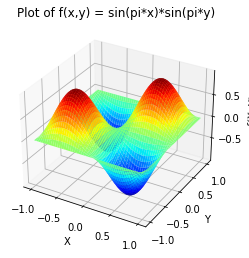

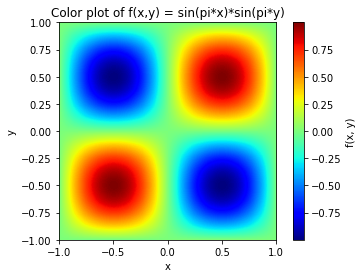

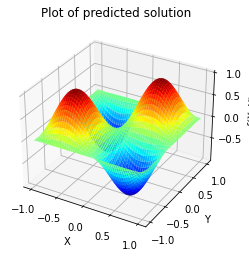

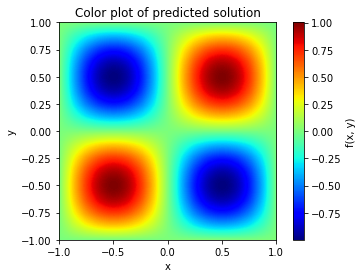

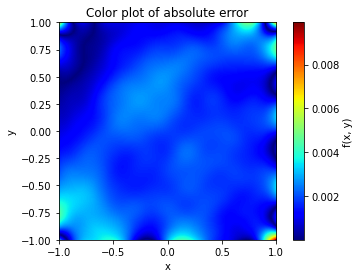

tensor(0.0044)


In [9]:
import matplotlib.pyplot as plt
def plot3D(X,Y,f,title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), f.numpy(), cmap='jet', edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    ax.set_title(title)
    plt.show()

    
def plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar):
    plt.imshow(f.numpy(), cmap='jet', origin='lower', extent=[x_l, x_r, y_l, y_r])
    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title_colorbar)

    plt.show()
    
    
def f_real(x,y):
    return torch.sin(np.pi*x)*torch.sin(np.pi*y)    

total_points = 200
x = torch.linspace(x_l,x_r,total_points).view((-1,1))
y = torch.linspace(y_l,y_r,total_points).view((-1,1))
X, Y = torch.meshgrid(x.view(-1,), y.view(-1,), indexing='ij')

f = f_real(X,Y)
 


x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],Y.transpose(1,0).flatten()[:,None]))
y_predict = model(x_test).detach()
 
reshaped_f = torch.reshape(y_predict, X.shape).transpose(1,0)

title = 'Plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot3D(X,Y,f,title)
title_colorbar = 'Color plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar)

title = 'Plot of predicted solution'
plot3D(X,Y,reshaped_f,title)
title_colorbar = 'Color plot of predicted solution'
plot_heat(x_l,x_r,y_l,y_r,reshaped_f,title_colorbar)


title_colorbar = 'Color plot of absolute error' 
plot_heat(x_l,x_r,y_l,y_r,abs(reshaped_f-f),title_colorbar) 

print(abs(reshaped_f-f).sum()/(f.size()[0]*f.size()[1])/(abs(f).sum()/(f.size()[0]*f.size()[1])))

### 4-D Poisson

The problem is set be  $$-\Delta u + \pi^2 u = f$$

#### import library

In [18]:
# %%
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
from math import *
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [19]:
torch.set_default_dtype(torch.float32)  # Set the default data type
torch.set_default_device('cpu')  # Set the default device (e.g., 'cuda' for GPU)

#### fundion definition

In [20]:
# exact solution
def u_exact(x):  
    u_intermediate  = torch.cos(pi*x)
    u_real = (u_intermediate.sum(1)).reshape((-1,1)) # u_intermediate.sum(1) 
    return u_real

# %%
def f_source(x):
    f_intermediate = torch.cos(pi*x)
    f_right_hand = 2*pi**2*(f_intermediate.sum(1)).reshape((-1,1)) # f_intermediate.sum(1) 
    return f_right_hand


def relative_error(x):
    
    u_predict = model(x)
    u_real = u_exact(x)
    value = torch.sqrt(torch.sum((u_predict - u_real )**2))/torch.sqrt(torch.sum((u_real )**2))
    return value

#### data preparation

In [21]:
Data_size = 2000
# %%
dimension = 4
def Gendata():
    x = torch.rand(Data_size, dimension)
#     x = 2*x-1         
    return x

In [22]:
x = Gendata()
f_right = f_source(x)
uexact = u_exact(x)

#### model definition

In [23]:
class Linear(nn.Module):
    #""" Copy of linear module from Pytorch, modified to have a Xavier init,
    #    TODO : figure out what to do with the bias"
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
#         torch.nn.init.xavier_uniform_(self.weight)
        nn.init.xavier_normal_(self.weight, gain=1.0)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?

    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight, self.bias)

#     def extra_repr(self):
#         return 'in_features={}, out_features={}, bias={}'.format(
#             self.in_features, self.out_features, self.bias is not None
#         )


class DGM_layer(nn.Module):
    #""" See readme for paper source"""
    def __init__(self, in_features, out_feature, residual=False):
        super(DGM_layer, self).__init__()
        self.residual = residual

        self.Z = Linear(out_feature, out_feature)
        self.UZ = Linear(in_features, out_feature, bias=True)
        self.G = Linear(out_feature, out_feature)
        self.UG = Linear(in_features, out_feature, bias=True)
        self.R = Linear(out_feature, out_feature)
        self.UR = Linear(in_features, out_feature, bias=True)
        self.H = Linear(out_feature, out_feature)
        self.UH = Linear(in_features, out_feature, bias=True)

    def forward(self, x, s):
        
        z = torch.tanh(self.UZ(x) + self.Z(s))
        g = torch.tanh(self.UG(x) + self.G(s))
        r = torch.tanh(self.UR(x) + self.R(s))
        h = torch.tanh(self.UH(x) + self.H(s * r))
        return (1 - g) * h + z * s

class DGM_model(nn.Module):

    def __init__(self, in_size, out_size, neurons, depth):
        super(DGM_model, self).__init__()
        self.input_layer = Linear(in_size, neurons)
        self.middle_layer = nn.ModuleList([DGM_layer(in_size, neurons) for i in range(depth)])
        self.final_layer = Linear(neurons, out_size)
        

    def forward(self, X):
        s = torch.tanh(self.input_layer(X))
        for i, layer in enumerate(self.middle_layer):
            s = torch.tanh(layer(X, s))

        return self.final_layer(s)

    def Loss_function(self,x):
        g=x.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x = f_X[:,0]
        grad_y = f_X[:,1]
        grad_z = f_X[:,2]
        grad_w = f_X[:,3]
        
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        f_YY = autograd.grad(grad_y, g, grad_outputs=torch.ones_like(grad_y), create_graph=True)[0][:, 1]
        f_ZZ = autograd.grad(grad_z, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 2]
        f_WW = autograd.grad(grad_w, g, grad_outputs=torch.ones_like(grad_y), create_graph=True)[0][:, 3]
        
        
        laplace_f=f_XX.unsqueeze(1) + f_YY.unsqueeze(1) + f_ZZ.unsqueeze(1) + f_WW.unsqueeze(1)
        
        
        
        f_right = f_source(x)
        part_1 = torch.sum((-laplace_f + pi**2*f - f_right)**2)/x.size()[0]

        Nb = 100
        xa1 = torch.rand(Nb, dimension) 
        xa1[:, 0] = torch.zeros(Nb)
        xa2 = torch.rand(Nb, dimension) 
        xa2[:, 0] = torch.ones(Nb)
        xb1 = torch.rand(Nb, dimension) 
        xb1[:, 1] = torch.zeros(Nb)
        xb2 = torch.rand(Nb, dimension) 
        xb2[:, 1] = torch.ones(Nb)
        xc1 = torch.rand(Nb, dimension) 
        xc1[:, 2] = torch.zeros(Nb)
        xc2 = torch.rand(Nb, dimension) 
        xc2[:, 2] = torch.ones(Nb)
        xd1 = torch.rand(Nb, dimension) 
        xd1[:, 3] = torch.zeros(Nb)
        xd2 = torch.rand(Nb, dimension) 
        xd2[:, 3] = torch.ones(Nb)
        sa1 = (torch.sum((model(xa1)-u_exact(xa1))**2)/xa1.size()[0]) 
        sa2 = (torch.sum((model(xa2)-u_exact(xa2))**2)/xa1.size()[0]) 
        sb1 = (torch.sum((model(xb1)-u_exact(xb1))**2)/xa1.size()[0]) 
        sb2 = (torch.sum((model(xb2)-u_exact(xb2))**2)/xa1.size()[0]) 
        sc1 = (torch.sum((model(xc1)-u_exact(xc1))**2)/xa1.size()[0]) 
        sc2 = (torch.sum((model(xc2)-u_exact(xc2))**2)/xa1.size()[0]) 
        sd1 = (torch.sum((model(xd1)-u_exact(xd1))**2)/xa1.size()[0])  
        sd2 = (torch.sum((model(xd2)-u_exact(xd2))**2)/xa1.size()[0]) 
        part_2 = sa1 + sa2 + sb1 + sb2 + sc1 + sc2 + sd1 + sd2

        lambda1 = 100.0
        return part_1 + lambda1 * part_2 / 8

In [24]:
model = DGM_model(4, 1, 50, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### model training

In [25]:
import torch.optim as optim
import torch.nn as nn
import time

traintime = 500

# %%
time_start = time.time()
for i in range(traintime):
    optimizer.zero_grad()
    x = Gendata()
#     x.requires_grad = True
    losses = model.Loss_function(x)
    losses.backward()
    optimizer.step()
    error = relative_error(x)
     
    
    if i % 1 == 0:
        print("current epoch is: ", i)
        print("current loss is: ", losses.detach())
        print("current relative error is: ", error.detach())
time_end = time.time()
print('total time is: ', time_end-time_start, 'seconds')

current epoch is:  0
current loss is:  tensor(1271.3282)
current relative error is:  tensor(1.1381)
current epoch is:  1
current loss is:  tensor(1141.0348)
current relative error is:  tensor(1.0530)
current epoch is:  2
current loss is:  tensor(1056.8669)
current relative error is:  tensor(0.9997)
current epoch is:  3
current loss is:  tensor(999.2152)
current relative error is:  tensor(0.9699)
current epoch is:  4
current loss is:  tensor(984.5749)
current relative error is:  tensor(0.9525)
current epoch is:  5
current loss is:  tensor(964.1046)
current relative error is:  tensor(0.9488)
current epoch is:  6
current loss is:  tensor(961.0621)
current relative error is:  tensor(0.9390)
current epoch is:  7
current loss is:  tensor(946.9645)
current relative error is:  tensor(0.9269)
current epoch is:  8
current loss is:  tensor(911.3537)
current relative error is:  tensor(0.9170)
current epoch is:  9
current loss is:  tensor(876.4898)
current relative error is:  tensor(0.9174)
current

current epoch is:  83
current loss is:  tensor(73.0664)
current relative error is:  tensor(0.2733)
current epoch is:  84
current loss is:  tensor(75.0307)
current relative error is:  tensor(0.2706)
current epoch is:  85
current loss is:  tensor(72.1988)
current relative error is:  tensor(0.2733)
current epoch is:  86
current loss is:  tensor(67.3361)
current relative error is:  tensor(0.2780)
current epoch is:  87
current loss is:  tensor(72.1302)
current relative error is:  tensor(0.2694)
current epoch is:  88
current loss is:  tensor(68.3614)
current relative error is:  tensor(0.2713)
current epoch is:  89
current loss is:  tensor(74.0934)
current relative error is:  tensor(0.2634)
current epoch is:  90
current loss is:  tensor(73.9276)
current relative error is:  tensor(0.2679)
current epoch is:  91
current loss is:  tensor(70.3399)
current relative error is:  tensor(0.2704)
current epoch is:  92
current loss is:  tensor(70.8605)
current relative error is:  tensor(0.2707)
current ep

current epoch is:  167
current loss is:  tensor(54.3924)
current relative error is:  tensor(0.2606)
current epoch is:  168
current loss is:  tensor(55.6748)
current relative error is:  tensor(0.2519)
current epoch is:  169
current loss is:  tensor(57.2053)
current relative error is:  tensor(0.2514)
current epoch is:  170
current loss is:  tensor(56.8365)
current relative error is:  tensor(0.2563)
current epoch is:  171
current loss is:  tensor(53.8576)
current relative error is:  tensor(0.2527)
current epoch is:  172
current loss is:  tensor(56.4552)
current relative error is:  tensor(0.2504)
current epoch is:  173
current loss is:  tensor(56.1654)
current relative error is:  tensor(0.2479)
current epoch is:  174
current loss is:  tensor(52.1520)
current relative error is:  tensor(0.2547)
current epoch is:  175
current loss is:  tensor(54.0848)
current relative error is:  tensor(0.2540)
current epoch is:  176
current loss is:  tensor(53.2972)
current relative error is:  tensor(0.2537)


current epoch is:  250
current loss is:  tensor(39.4731)
current relative error is:  tensor(0.2173)
current epoch is:  251
current loss is:  tensor(39.7062)
current relative error is:  tensor(0.2156)
current epoch is:  252
current loss is:  tensor(37.4753)
current relative error is:  tensor(0.2207)
current epoch is:  253
current loss is:  tensor(40.1006)
current relative error is:  tensor(0.2141)
current epoch is:  254
current loss is:  tensor(38.0067)
current relative error is:  tensor(0.2119)
current epoch is:  255
current loss is:  tensor(37.0422)
current relative error is:  tensor(0.2145)
current epoch is:  256
current loss is:  tensor(35.0350)
current relative error is:  tensor(0.2171)
current epoch is:  257
current loss is:  tensor(37.5243)
current relative error is:  tensor(0.2103)
current epoch is:  258
current loss is:  tensor(38.0186)
current relative error is:  tensor(0.2085)
current epoch is:  259
current loss is:  tensor(38.3525)
current relative error is:  tensor(0.2045)


current epoch is:  332
current loss is:  tensor(20.8407)
current relative error is:  tensor(0.1531)
current epoch is:  333
current loss is:  tensor(21.1456)
current relative error is:  tensor(0.1586)
current epoch is:  334
current loss is:  tensor(21.1687)
current relative error is:  tensor(0.1577)
current epoch is:  335
current loss is:  tensor(20.8151)
current relative error is:  tensor(0.1537)
current epoch is:  336
current loss is:  tensor(20.6704)
current relative error is:  tensor(0.1509)
current epoch is:  337
current loss is:  tensor(21.0269)
current relative error is:  tensor(0.1520)
current epoch is:  338
current loss is:  tensor(21.2976)
current relative error is:  tensor(0.1502)
current epoch is:  339
current loss is:  tensor(19.6220)
current relative error is:  tensor(0.1491)
current epoch is:  340
current loss is:  tensor(19.7162)
current relative error is:  tensor(0.1502)
current epoch is:  341
current loss is:  tensor(20.7547)
current relative error is:  tensor(0.1478)


current epoch is:  414
current loss is:  tensor(10.2257)
current relative error is:  tensor(0.1088)
current epoch is:  415
current loss is:  tensor(10.2275)
current relative error is:  tensor(0.1063)
current epoch is:  416
current loss is:  tensor(10.2864)
current relative error is:  tensor(0.1113)
current epoch is:  417
current loss is:  tensor(10.1332)
current relative error is:  tensor(0.1108)
current epoch is:  418
current loss is:  tensor(9.9882)
current relative error is:  tensor(0.1088)
current epoch is:  419
current loss is:  tensor(9.8435)
current relative error is:  tensor(0.1063)
current epoch is:  420
current loss is:  tensor(9.8757)
current relative error is:  tensor(0.1037)
current epoch is:  421
current loss is:  tensor(9.7616)
current relative error is:  tensor(0.1034)
current epoch is:  422
current loss is:  tensor(9.4601)
current relative error is:  tensor(0.1080)
current epoch is:  423
current loss is:  tensor(9.6092)
current relative error is:  tensor(0.1070)
curren

current epoch is:  497
current loss is:  tensor(6.3301)
current relative error is:  tensor(0.0861)
current epoch is:  498
current loss is:  tensor(6.8059)
current relative error is:  tensor(0.0827)
current epoch is:  499
current loss is:  tensor(6.4654)
current relative error is:  tensor(0.0867)
total time is:  111.01676630973816 seconds


## ---------------------------------------------------------------------------------------------------------------------------------
##  <center> Deep Ritz Method
## --------------------------------------------------------------------------------------------------------------------------------
#### https://link.springer.com/article/10.1007/s40304-018-0127-z

The Deep Ritz Method leverages the neural network representation of functions within the framework of the Ritz Method.

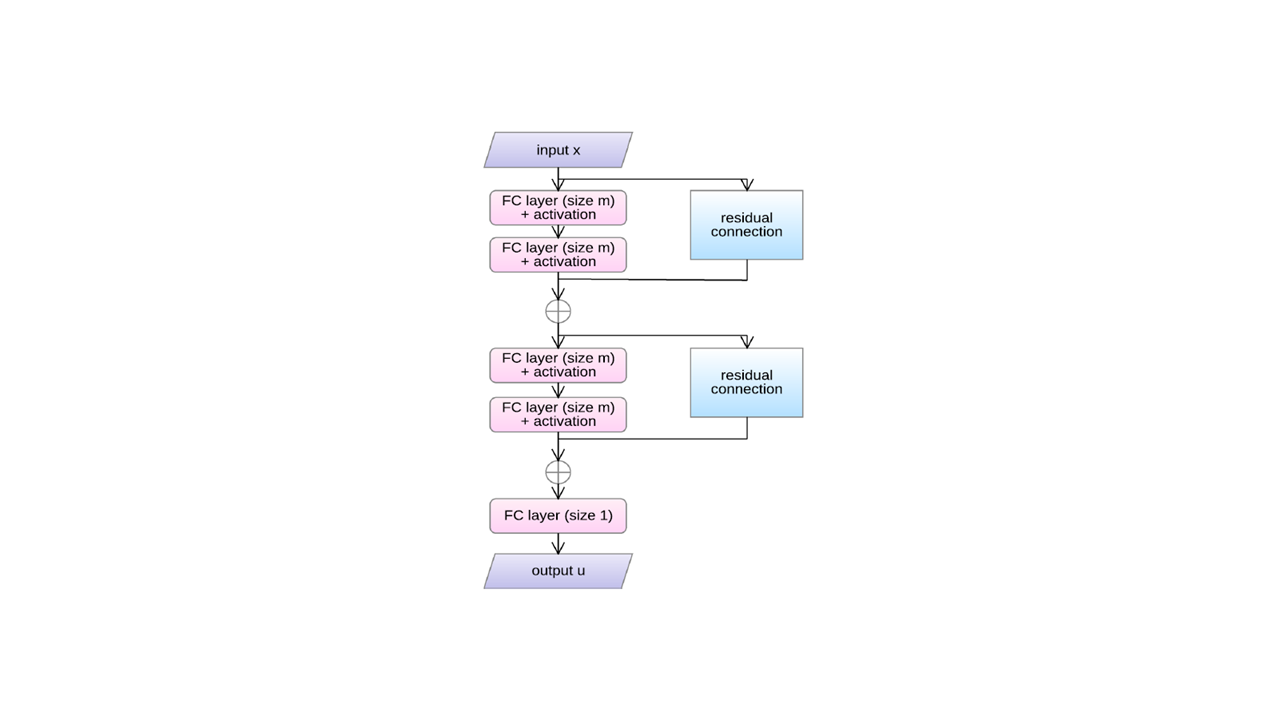

#### import library

In [1]:
# %%
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
from math import *
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from torch import optim, autograd

In [2]:
torch.set_default_dtype(torch.float32)  # Set the default data type
torch.set_default_device('cpu')  # Set the default device (e.g., 'cuda' for GPU)

#### fundion definition

In [3]:
# exact solution
def u_exact(x):  
    u_intermediate  = torch.sin(pi*x)
    u_real = (u_intermediate[:,0]*u_intermediate[:,1]).reshape((-1,1)) # u_intermediate.sum(1) 
    return u_real

# %%
def f_source(x):
    f_intermediate = torch.sin(pi*x)
    f_right_hand = 2*pi**2*(f_intermediate[:,0]*f_intermediate[:,1]).reshape((-1,1)) # f_intermediate.sum(1) 
    return f_right_hand


def relative_error(x):
    
    u_predict = model(x)
    u_real = u_exact(x)
    value = torch.sqrt(torch.sum((u_predict - u_real )**2))/torch.sqrt(torch.sum((u_real )**2))
    return value

#### data preparation

In [4]:
Data_size = 2000
x_l = -1
x_r = 1
y_l = -1
y_r = 1
# %%
dimension = 2

In [5]:

def get_collocation_points(N=128*2,d = dimension):
    """
    randomly sample N points from interior of [-1,1]^d
    """
    return torch.rand(N,d) * 2 - 1

def get_edge_points(N=33):
    index = torch.rand(N, 1)
    index1 = torch.rand(N,1) * 2 - 1
    
     
    xbt = torch.cat((index1, torch.ones_like(index1)), dim=1) # y = 1
     
    xbb = torch.cat((index1, torch.full_like(index1, -1)), dim=1)  # y = -1
     
    xbl = torch.cat((torch.ones_like(index1), index1), dim=1)      # x = 1
    xbr = torch.cat((torch.full_like(index1, -1), index1), dim=1)  # x = -1
    xb = torch.cat((xbt, xbb, xbl, xbr), dim=0)

    return xb
 

#### model definition

In [14]:
class Block(nn.Module):

    def __init__(self, in_N, width, out_N):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.Tanh()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x


class DRM(nn.Module):

    def __init__(self, in_N, m, out_N, depth=4):
        super(DRM, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x
    
    def loss_function(self,device):
        xr = get_collocation_points()
        xb = get_edge_points()

        xr = xr.to(device)
        xb = xb.to(device)

        xr.requires_grad_()
        output_r = self.forward(xr)
        output_b = self.forward(xb)
        grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        f = f_source(xr)
         

        loss_r = 0.5 * torch.sum(torch.pow(grads, 2),dim=1)- output_r*f
        loss_r = torch.mean(loss_r)
        loss_b = torch.mean(torch.pow(output_b,2))
        loss = 4 * loss_r + 9 * 500 * loss_b
        return loss

    
def weights_init(model):
    if isinstance(model, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(model.weight)
        nn.init.constant_(model.bias, 0.0)    

#### model training

False
DRM(
  (phi): Tanh()
  (stack): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-4): 4 x Block(
      (L1): Linear(in_features=20, out_features=20, bias=True)
      (L2): Linear(in_features=20, out_features=20, bias=True)
      (phi): Tanh()
    )
    (5): Linear(in_features=20, out_features=1, bias=True)
  )
)
epoch: 0 loss: 4382.06689453125
epoch: 100 loss: 0.13891786336898804
epoch: 200 loss: -0.08162516355514526
epoch: 300 loss: -0.3024962246417999
epoch: 400 loss: -0.5036050081253052
epoch: 500 loss: -0.46867507696151733
epoch: 600 loss: -1.040137529373169
epoch: 700 loss: -1.197112798690796
epoch: 800 loss: -1.118285059928894
epoch: 900 loss: -2.5513854026794434
epoch: 1000 loss: -2.007286548614502
epoch: 1100 loss: -3.086714029312134
epoch: 1200 loss: -3.6291542053222656
epoch: 1300 loss: -2.9587647914886475
epoch: 1400 loss: -5.18377161026001
epoch: 1500 loss: -3.3247268199920654
epoch: 1600 loss: -3.024808883666992
epoch: 1700 loss: -7.764729

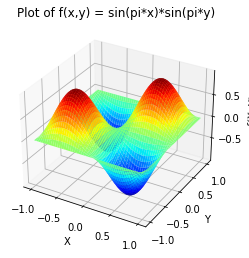

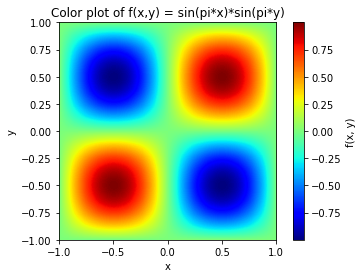

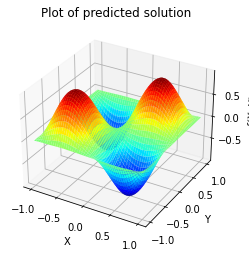

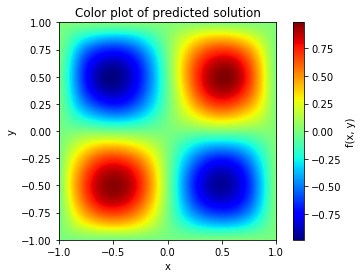

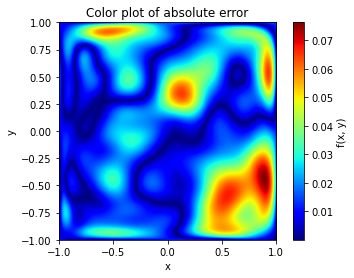

tensor(0.0521)


In [18]:
epochs = 15000

in_N = 2
m = 20
out_N = 1

print(torch.cuda.is_available())
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
# Notice that the real code is "device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')"
# Although my computer supports cuda ,  its running speed is slower tahn 'cpu', ...........
model = DRM(in_N, m, out_N).to(device)
model.apply(weights_init)

optimizer = optim.Adam(model.parameters(), lr=3e-3)
print(model)

best_loss, best_epoch = 1000, 0
for epoch in range(epochs+1):

    optimizer.zero_grad()
    loss = model.loss_function(device)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', loss.item())
        if epoch > int(4 * epochs / 5):
            if torch.abs(loss) < best_loss:
                best_loss = torch.abs(loss).item()
                best_epoch = epoch
                torch.save(model.state_dict(), 'new_best_deep_ritz1.mdl')
print('best epoch:', best_epoch, 'best loss:', best_loss)




def plot3D(X,Y,f,title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), f.numpy(), cmap='jet', edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    ax.set_title(title)
    plt.show()


def plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar):
    plt.imshow(f.numpy(), cmap='jet', origin='lower', extent=[x_l, x_r, y_l, y_r])
    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title_colorbar)

    plt.show()


def f_real(x,y):
    return torch.sin(np.pi*x)*torch.sin(np.pi*y)    

total_points = 200
x = torch.linspace(-1,1,total_points).view((-1,1))
y = torch.linspace(-1,1,total_points).view((-1,1))
X, Y = torch.meshgrid(x.view(-1,), y.view(-1,), indexing='ij')

f = f_real(X,Y)



x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],Y.transpose(1,0).flatten()[:,None]))
y_predict = model(x_test).detach()

reshaped_f = torch.reshape(y_predict, X.shape).transpose(1,0)

title = 'Plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot3D(X,Y,f,title)
title_colorbar = 'Color plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot_heat(-1,1,-1,1,f,title_colorbar)

title = 'Plot of predicted solution'
plot3D(X,Y,reshaped_f,title)
title_colorbar = 'Color plot of predicted solution'
plot_heat(-1,1,-1,1,reshaped_f,title_colorbar)


title_colorbar = 'Color plot of absolute error' 
plot_heat(-1,1,-1,1,abs(reshaped_f-f),title_colorbar) 
print(abs(reshaped_f-f).sum()/(f.size()[0]*f.size()[1])/(abs(f).sum()/(f.size()[0]*f.size()[1])))




#### plot results